# **Attention - Tradutor Inglês para Português**

- Neste notebook vamos criar um algoritmo capaz de traduzir sentenças do Inglês para o Português.
- Basicamente, utilizamos o esquema Seq2Seq e adicionamos a atenção a ele.

In [ ]:
#Garantir que keras e tensorflow estão instalados
! pip install keras
! pip install tensorflow

In [ ]:
#Garantir que está usando a versão mais recente de Keras
! pip install keras --upgrade

# **Attention**

# **Many-to-One Task**

Existem duas formas principais de lidar com a tarefa de múltiplas entradas para uma única saída:

1) Passamos a sequência por toda a RNN e passamos a saída da RNN por uma última camada densa, completamente conectada. Com isso, obtemos uma previsão condicionada à sequência de entrada como um todo.
- Esta abordagem faz sentido porque desejamos que a RNN realize a previsão após considerar toda a sequência de input.
- Por exemplo, seria estranho se nós consistentemente lêssemos apenas metade da sentença para determinar o seu significado.


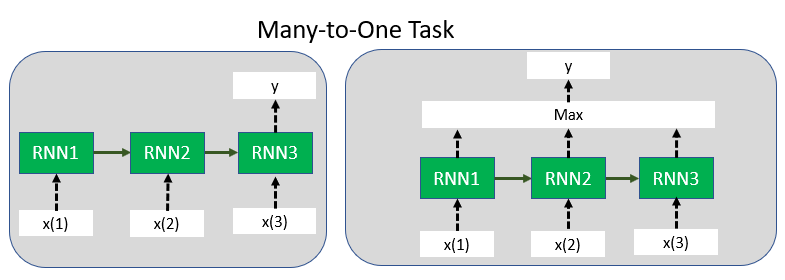

# **Long-term Dependencies**

- Sabemos que LSTMs e GRUs são capazes de aprender dependências de longo prazo (long-term dependencies).
 - Quão longas seriam, contudo, essas dependências?

2) Em alguns casos, desejamos conhecer um hidden state intermediário. Neste caso, utilizamos a segunda abordagem, que consiste em **executar um Global Max Pooling sobre todos os estados** (final e intermediários).

### **Executar um maxpool sobre todos os estados de uma RNN é equivalente a executar um maxpool sobre todas as características (features) de uma CNN.**
- Basicamente, o maxpool "diz" ao algoritmo: **selecione a característica (feature) mais importante**.
- De outra forma: "Onde está a característica relevante?".

Por sua vez, tomar apenas o estado de saída equivale a esperar que a RNN tenha não só encontrado a característica relevante, mas também que ela **se "lembre" de todo o caminho percorrido na busca por esta característica** (ou seja, esperamos que o último estado guarde as informações de todos os estados).

## Abordagens para o cálculo do valor máximo.

1) **Normal max ("hardmax")**: toma o valor máximo e ignora (esquece) todos os outros valores.

2) **Softmax**: calcula a distribuição de probabilidades para todos os elementos de modo a avaliar o quanto é preciso "se importar" com cada elemento. É uma abordagem probabilística para a avaliação do máximo.
- Uma vez que o deep learning é probabilístico, esta abordagem fornece o quanto cada hidden state importa (**ou seja, o quão importante é cada um dos estados**).

### Os modelos de atenção também são modelos Seq2Seq.

- Sendo assim, eles também são formados por um conjunto de sistemas encoder-decoder.

## **Porém, o Encoder agora é uma LSTM bidirecional, com saída de formato Tₓ x 2M.**

Note que o LSTM bidirecional aplicado ao encoder nos fornece uma sequência completa de hidden states com comprimento Tₓ.

- Como o LSTM é bidirecional, estamos calculando os estados tanto na ordem direta, da primeira para a última unidade recorrente; quanto na ordem reversa, da última para a primeira unidade. A seguir, este conjunto de estados é fornecido como alimentação do decoder.

Além disso, **ignoramos por completo os cell states da LSTM bidirecional do encoder**.

O decoder tomará todos os hidden states h provenientes do encoder e produzirá uma saída, que pode ser a tradução de uma sentença.

# **Attention vs. Regular Seq2Seq**

- Vamos chamar os **hidden states do encoder de h e os hidden states do decoder de s**.

"Regular Seq2Seq": tomamos o último hidden state do encoder e passamos ele como o estado inicial do LSTM do decoder.
- Assim, para um Seq2Seq convencional, h(Tₓ) = s(0), onde h(Tₓ) representa o hidden state final do encoder (após o comprimento Tₓ); e s(0) é o hidden state inicial (input) do decoder ("side feed").

Attention: enquanto o encoder do Seq2Seq covencional se preocupava apenas com h(Tₓ), em Attention utilizamos uma RNN bidirecional **porque nos importamos com todos os hidden states h**.
- Assim, todos os h serão alimentados a algum tipo de "calculadora de atenção".
- Esta calculadora de atenção nos retornará um **vetor final, o qual chamaremos de contexto**.
### **O contexto nos informará qual hidden state h (ou seja, qual característica da sequência processada) é mais importante**.

Como todos os h estão sendo passados como alimentação do LSTM do decoder, não há mais necessidade de igualar s(0) a um valor h. Assim, definimos s(0) = 0.

Uma vez que o sistema de decoding gerará apenas uma palavra por vez no processo de previsão, **a LSTM do decoder não pode ser bidirecional**.
- No decoder, temos de usar obrigatoriamente uma LSTM simples.

# **Vetor de contexto ("context vector")**

Uma unidade LSTM do decoder será alimentada com um vetor lateral s(t-1), hidden state obtido como saída da LSTM anterior (também do decoder).
- Além disso, ele será alimentado por um vetor de contexto, que contém informações sobre todos os estados das unidades LSTM do encoder.

**O vetor de contexto é simplesmente a média ponderada de todos os hidden states**.
- Utilizamos o α para simbolizar os pesos desta média ponderada.
- Os valores de α representam o quão importante é cada hidden state para obter aquela saída em particular.
- Os valores **α são denominados pesos de atenção ("attention weights")**.

# **Cálculo dos α ("attention weights")**

Os valores de α são obtidos por meio de uma rede neural.
- Isto torna toda a rede de atenção diferenciável, de ponta-a-ponta.
- Assim, podemos treinar todo o sistema de uma vez só.
- O sistema como um todo é uma grande rede neural composta de várias redes neurais menores.

Temos duas sequências a considerar, cada uma com seus próprios passos separando valores consecutivos: a sequência de input (alimentação, encoder); e a sequência de output (saída, no decoder).
- Para cada passo da sequência de saída, consideramos todos os passos da sequência de entrada (isto porque a LSTM do encoder é bidirecional).
- Seja `t` o instante/iteração do decoder. Se temos Ty unidades recorrentes no decoder (ou seja, Ty iterações da RNN), então `t = 1, 2, 3, ..., Ty`. O hidden state obtido após uma unidade LSTM do **decoder** é representado por `h`.
- Seja `t'` o instante/iteração do encoder. Como visto, temos Tₓ unidades recorrentes no encoder (Tₓ iterações da RNN). Deste modo, `t' = 1, 2, 3, ..., Tₓ`. `h'` representa, então, o hidden state de uma dada iteração do **encoder**.
  - Assim, cada passo da saída analisa todos os hidden states da entrada.
  - **Como a cada hidden state corresponde um α, teremos um total de Tₓ valores α**.
  - Para cada passo t do decoder (saída), precisamos analisar todos os valores h' do encoder (entrada), os quais são obtidos para cada um dos passos `t' = 1, 2, 3, ..., Tₓ`. Isto significa que necessitamos de um valor α (attention weight) para cada um dos possíveis valores t'.

O vetor de input é calculado como o produto escalar entre cada um dos valores `h'(t)` e os correspondentes valores `α(t)`. 
- Este vetor de input é concatenado a `s(t-1)`, hidden state do LSTM anterior do decoder (side input). 
- Após esta etapa de concatenação, o vetor é utilizado como alimentação da unidade `t`do Decoder.

### **Assim, onde eu "presto atenção" depende não apenas dos hidden states, mas também de onde eu estou na sequência de saída.**
- Por exemplo, os h com os quais eu me preocupo no início do processo de gerar a saída são diferentes daqueles com que eu me preocupo quando estou quase terminando de gerar a nova sentença.
- Caso os valores de α não dependessem de s(t-1), mas apenas dos valores h, então os pesos de atenção seriam os mesmos para cada etapa.
  - Isto não faria sentido, pois sequer necessitaríamos de gerar a "atenção".

### Precisamos das informações registradas nos estados s porque são elas que nos informam o **contexto** a respeito de onde estamos na sequência de saída.
- Lembrando, s= alimentação lateral, estado da RNN anterior do decoder, e s(0) = 0.

# **Exemplo**

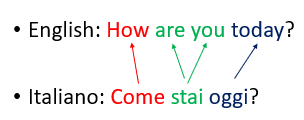

Neste exemplo, desejamos traduzir a frase "How are today?" do inglês para o italiano.
- Note que a segunda frase (frase traduzida) apresenta menos palavras que a sentença original.

1) Ao gerar a primeira palavra ("Come"), minha atenção está voltada à primeira palavra da sentença original, "How".

2) Ao gerar a segunda palavra ("stai"), minha atenção não está mais sobre a palavra "How". **A atenção se deslocou agora para duas palavras ao mesmo tempo: "are you"**.

### **Assim, a porção da sentença original para a qual eu devo prestar atenção varia à medida que eu gero novas palavras de saída**.
- Em outras palavras, o modelo deve ser tal que a atenção se desloque pela sequência de input de acordo com a palavra em particular que tentamos gerar (de outra forma: de acordo com qual trecho desejamos traduzir naquele instante).
- Para que isto seja possível, a atenção deve depender não apenas de h, mas também de s.

# **Cálculo dos "Attention Weights" α - Pseudocódigo**

1) Concatenar os vetores que armazenam os hidden states s(t-1) e h(t').

- Como visto, este vetor concatenado será a alimentação de uma rede neural convencional (feedforward neural network). Esta rede será formada por duas camadas densas (completamente conectadas), e terá a função de calcular os pesos α para o posterior cálculo do vetor de atenção.

```
z = concat[ s(t-1), h(t') ]
z = tanh(W1*z + b1) # layer 1 of ANN
z = softmax(W2*z + b2) # layer 2 of ANN 
```
2) A primeira camada densa é ativada pela tangente hiperbólica, de modo a aprender não linearidades.

3) A segunda camada densa é ativada pela função softmax. Como visto, ao contrário do "hardmax", que retorna um único valor, o "softmax" fornece uma abordagem probabilística para o cálculo do máximo.
### **A função softmax retornará uma distribuição de probabilidade que representará o quanto de atenção (a cada instante) o modelo deve prestar a cada um dos valores de estado h**.


Uma vez que os valores de α representam probabilidades, a soma deles deve resultar em 1 (100% de probabilidade).

- Note, porém, que ao calcular α(t') como

```
α(t') = z = softmax(W2*z + b2)
```
conseguimos calcular um único h'(t) por vez, o que faz o uso da função softmax não ter sentido. Afinal, para ter sentido, devemos ter um conjunto de dados h'(t) para o qual possamos construir uma distribuição estatística de valores.

Assim, para ser utilizada de forma apropriada, a função softmax deve ser calculada sobre todas as funções de ativação e todos os hidden states de t1 a tₓ.
- É isto que fará com que a soma dos valores de α seja igual a 1, resultando, de fato, em uma média ponderada dos hidden states.
- **Mais uma vez, note que o peso α associado a um determinado hidden state h deve representar: a probabilidade de que este hidden state h seja aquele para o qual o algoritmo deve prestar atenção naquele instante**. 
- Quanto maior a probabilidade α, maior a atenção que deve ser dada àquele hidden state no instante analisado.

A solução, então, é calcular os valores de α(t') para todos os valores t' = 1, ..., Tₓ. Para isso, utilizamos a mesma rede neural descrita no pseudocódigo acima, **mas sem a última etapa de aplicação da função softmax**.
- Assim, esta rede será aplicada por um total de Tₓ vezes.

A função softmax final deve ser empregada sobre todas as saídas h(t') obtidas. 

Ela será, na verdade, **uma função softmax "especial"/modificada**. Assim, seja `out(t') a saída da rede neural para o tempo t'`:
```
α(t') = [exp(out(t'))]/[Σ(exp(out(τ)))], τ ϵ [1, Tₓ]
```
Isto naturalmente leva à pergunta sobre como deve se comportar s(t-1).
- Isso porque temos um único valor s(t-1) para cada unidade recorrente do Decoder.
- **s(t-1) será "copiado" para cada valor h(t')**, como mostra o pseudocódigo a seguir:

```
out(1) = NeuralNet([ s(t-1), h(1) ])
out(2) = NeuralNet([ s(t-1), h(2) ])
...
out(Tₓ) = NeuralNet([ s(t-1), h(Tₓ) ])

alpha = α = softmax(out)
```
Desta forma, cada hidden state h(t') será concatenado a uma cópia do estado s(t-1), a alimentação lateral. 
- O vetor formado pela concatenação de h(t') com s(t-1) é utilizado como alimentação da rede neural de decoding.







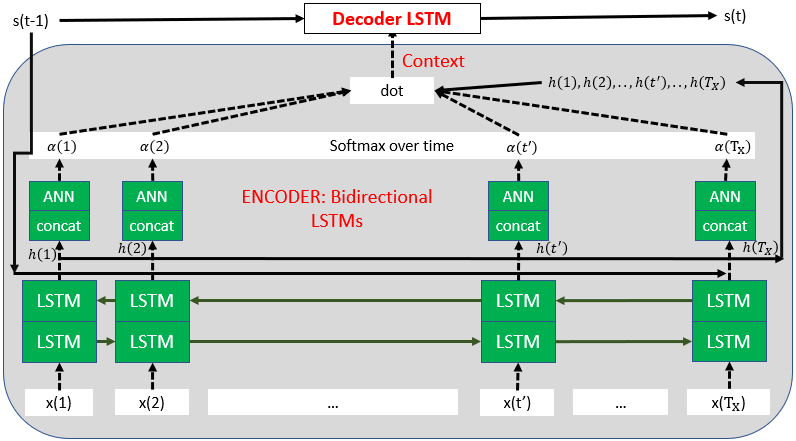

# **A figura acima resume a arquitetura do "Attention Model" - uma adaptação da arquitetura Seq2Seq**

## Encoder (parte 1)
- A sequência de input (alimentação) x(1), x(2), ..., x(t'), ..., x(Tₓ) é alimentada ao sistema de encoding.
- O sistema de encoding é formado por LSTMs bidirecionais.
- Isto significa que os hidden states h(t') são calculados tanto com base no sentido direto (forward), quanto no sentido reverso (backwards).
- Ignoramos por completo os cell states c - desejamos somente os hidden states h.
  - Isso equivale a manter `return_sequences = True` (retorna os hidden states h) e return_states = False (não retorna os cell states c).
- Cada unidade t' da LSTM é alimentada por x(t') e pelos hidden states da LSTM anterior (sentido direto) e da LSTM seguinte (hidden state no sentido reverso).

## Decoder (parte 1)
- O decoder é formado por unidades LSTM convencionais.
- Aqui, temos a mesma situação que o Seq2Seq convencional: uma vez que **geramos uma única palavra/elemento da sequência por vez; e como não sabemos a princípio qual será o resultado de saída** (e.g., não sabemos qual será a tradução de uma sentença; ou qual a resposta que o chatbot fornecerá após a interação com o usuário), não podemos utilizar LSTMs bidirecionais, apenas convencionais.
- Os hidden states das RNNs do decoder são chamados s(t) - side feed, alimentação lateral.
- Definimos `s(0) = 0`. **Esta é uma diferença importante em relação à arquitetura Seq2Seq tradicional**: no Seq2Seq, não utilizamos LSTMs bidirecionais, e o primeiro hidden state do decoder s(0) é sempre igual ao último hidden state do encoder h(Tₓ).
- **Cada unidade LSTM t do decoder é alimentada simultaneamente: pelo hidden state s(t-1) da unidade LSTM anterior; e por um vetor de contexto (_context vector_).** 
- Isto é repetido para cada uma das t = 1, 2, ..., t, ..., Ty unidades LSTM do decoder.

## Encoder (parte 2) - **cálculo dos Attention Weights α**
- **O cálculo dos pesos constitui o mecanismo de atenção.**
- Os hidden states h(1), h(2), ..., h(t'), ..., h(Tₓ) resultantes das LSTMs bidirecionais do encoder são concatenados ao hidden state s(t-1) do decoder.
- Repare que o hidden state s(t-1) é repetido (copiado) para todos os valores h(t'). 

#### Assim, para cada valor t = 1, 2, ..., t, ..., Tₓ, teremos um total de Tₓ vetores concatenados `[s(t-1), h(t')]`:
```
[s(t-1), h(1)]
[s(t-1), h(2)]
...
[s(t-1), h(t')]
...
[s(t-1), h(Tₓ)]
```
Cada um dos Tₓ vetores concatenados referentes a s(t-1) são alimentados a uma rede neural densa (feedforward neural network, completamente conectada).
- Esta rede neural é ativada pela função tangente hiperbólica, que tem a função de capturar aspectos de não linearidade na avaliação dos pesos α.
- A função softmax é aplicada a todos os t' do encoder, de modo a obter os pesos de atenção α(t').
- Estes pesos representam o quanto o algoritmo deve prestar atenção a cada elemento da sequência de hidden states h, a cada instante considerado. 
  - A importância ou atenção que o algoritmo deve dar a cada elemento da sequência varia à medida que avançamos na sequência.
- **Os valores α representam pesos de uma média ponderada. Assim, sua soma deve ser igual a 1**.
- A função softmax consiste em uma abordagem probabilística para a avaliação do máximo.
- **Softmax calcula a distribuição de probabilidades para todos os elementos. Com isto, esta função é capaz de avaliar o quanto é preciso "se importar" com cada elemento.** 
  - Esta abordagem fornece o quanto cada hidden state importa (**ou seja, o quão importante é considerar cada um dos estados**).
- No caso de a modelagem de atenção ser destinada à tradução de textos, **os valores de α nos informarão o quanto cada hidden state h é importante para traduzir uma determinada palavra** ou expressão da sentença.

## Encoder (parte 3) - **obtenção do context vector**
- Realizamos o produto escalar ("dot product") do vetor de pesos α = α(1), α(2), ..., α(t'), ..., α(Tₓ) com o vetor de hidden states h = h(1), h(2), ..., h(t'),... h(Tₓ).
- Como os valores de α representam os pesos, este produto escalar é uma **média ponderada (soma ponderada) dos hidden states h**.

- **A saída deste produto é a saída do Encoder.** 
  - **O vetor de encoding agora é chamado vetor de contexto ("context vector").** 
  - **O vetor de contexto representa e sintetiza o quanto o algoritmo deve prestar atenção a cada elemento da sequência.**
- O vetor de contexto armazena, portanto, o contexto da sentença ou sequência como um todo. 
  - Em NLP, este é exatamente o contexto ou assunto da conversa.
- O vetor de contexto guarda, então, as informações de memória.
- Basicamente, o vetor de contexto informa ao algoritmo qual o valor de h(t') com o qual ele deve se preocupar mais a cada instante.
- **Sendo um vetor de encoding, o vetor de contexto resumirá toda a informação contida na sentença ou sequência de entrada**. 
- Esta informação será traduzida pelo decoder. 
  - A partir dela, o decoder obterá uma sentença de saída.
- **A sentença de saída pode ser a sequência original traduzida para uma língua de interesse**.

## Decoder (parte 2) - obtenção da sentença ou sequência de saída
- Cada unidade LSTM do decoder recebe duas alimentações: 
  - s(t-1), estado obtido como saída da LSTM anterior do decoder; 
  - E o vetor de contexto. O vetor de contexto é obtido: ao se concatenar s(t-1) com cada hidden state h(t') do encoder; e, a seguir, ao se utilizar este vetor concatenado como alimentação de uma rede neural.
- A unidade LSTM do **decoder decodifica estas informações.** 
  - Com isto, ela gera um elemento da sequência de saída; e um hidden state s(t) que alimentará a LSTM seguinte do decoder.
- O elemento de saída pode ser uma palavra de uma frase traduzida para uma língua-alvo; ou pode ser a próxima palavra gerada por um chatbot, por exemplo.




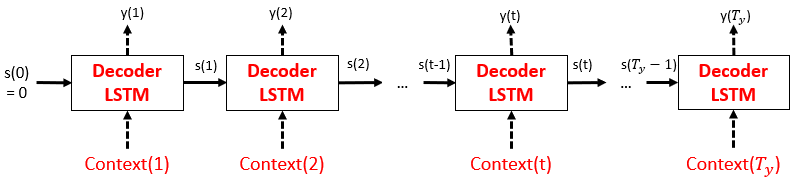

Como cada unidade LSTM do decoder gera uma única saída y(t) por vez, o processo é repetido Ty vezes, onde Ty é o total de unidades LSTM do decoder.
- Note que a saída do decoder pode ser a próxima palavra da sequência (sentença) que está sendo traduzida; ou a próxima frase gerada pelo chatbot **com base no contexto.**
- Como visto na arquitetura Seq2Seq tradicional, este total de saídas Ty pode ou não ser igual ao número de elementos Tₓ da sequência de input.

#### Isto é descrito no pseudocódigo abaixo:

```
h = encoder(input)

s = 0
#s is the null matrix: a bunch of zeros
for t in range(Ty):
#this loop is repeated Ty times

  alphas = neural_net(s, h)
  context = dot(alphas, h)
  o, s = decoder_lstm (context, initial_state = s)
  output_prediction = dense(o)
  #softmax is applied in this last dense layer
  #this final dense layer leads to the predicted output word.

  #this for loop should remind you of the "decoder function" 
  #from the poetry generator  
```
Repare uma diferença importante para o decoder Seq2Seq tradicional: **no modelo de atenção, nós trabalhamos com variáveis simbólicas, e não com NumPy arrays.**


#**Teacher Forcing**

- No teacher forcing, é a palavra correta (elemento já rotulado da sequência/ a tradução correta já validada) que é utilizada como alimentação inferior de cada unidade LSTM do decoder.
- Assim, **as etapas anteriores estão em conflito com o teacher forcing, já que empregam o vetor de contexto como alimentação inferior**.
- Em outras palavras: o vetor de contexto está ocupando a posição de entrada que seria utilizada para alimentar as redes neurais com a palavra correta da tradução já validada.

###**Para empregar o teacher forcing, a solução é concatenar o target (palavra traduzida e validada) ao vetor de contexto.**

O pseudocódigo será, então:

```
# Training
input(t) = [ context(t), target(t-1) ]

# Prediction
input(t) = [ context(t), y(t-1) ]
```
- Lembre-se que o teacher forcing requer um offset de uma unidade da sequência, o qual corresponde ao token de início da sentença `<sos>`.
- Sem este offset, o algoritmo simplesmente aprenderia a copiar a entrada na saída, algo sem utilidade.
- Este offset está representado no argumento `(t-1)`.

Também seria possível utilizar este vetor concatenado como input de uma camada densa anterior à unidade LSTM do decoder.
  - Esta camada estaria posicionada entre o vetor de contexto e a LSTM do decoder (ou seja, o a alimentação passaria por mais esta rede neural densa adicional antes de ser levada ao decoder); 
  - O uso desta camada densa é feito para "contrair" ou reduzir as dimensões do vetor de input do decoder.
- Assim, esta camada densa seria um estágio intermediário: o input (t) da figura abaixo alimentaria a camada densa, e a saída da camada densa é que alimentaria o decoder.
  - Note que o input(t) da figura abaixo é **o vetor de contexto concatenado**: à resposta conhecida e validada `target(t-1)`; ou à resposta gerada no instante anterior, `y(t-1)`. 
  - O vetor de contexto, por sua vez, é calculado conforme descrito acima. 
  - **Esta nova concatenação do vetor de contexto à resposta ou ao target é realizada para permitir o teacher forcing.**


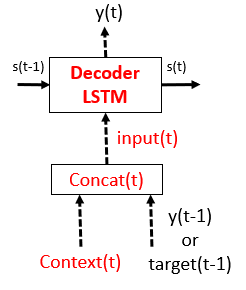

## **Assim, durante o treinamento:**
- Temos a palavra **correta que deveria ser gerada** na unidade LSTM anterior: `target(t-1)`;
- Esta palavra é concatenada ao vetor de contexto antes de ser empregada como alimentação inferior da LSTM.

## **Já na etapa de prever ou gerar a próxima palavra (elemento da sequência):** 
- Temos a palavra **gerada** na LSTM anterior: `y(t-1)`;
- Esta palavra é concatenada ao vetor de contexto antes de ser empregada como alimentação inferior da LSTM.

# **Teacher forcing: considerações finais**

- Na arquitetura Seq2Seq convencional, fornecemos de uma vez só toda a sequência target (respostas ou traduções já validadas de sentenças). 
  - São sequências de input para as quais já se conhece a tradução, ou seja, para as quais já sabemos a classificação correta.
- Isso porque, **no Seq2Seq tradicional, um único chamado da rede neural de gerar toda a sequência de saída** (sentença traduzida).

#### **No modelo de atenção, precisamos executar todos os Ty passos do loop do decoder**.
- Isto é necessário porque cada um dos vetores de contexto que alimentam a LSTM (decoder) no intante t depende do valor s(t-1), hidden state obtido como saída da LSTM no instante t-1.
  - Lembre-se que os **hidden states são responsáveis por armazenar as informações de memória da LSTM.**
  - São os hidden states que permitem que as RNNs modelem contextos e séries temporais.
- Como visto, s(t-1) é copiado e concatenado a cada um dos valores que formarão a alimentação inferior do decoder.

#### **Para isso, precisamos quebrar a sequência target usada como input do teacher forcing em Ty partes**.
- Cada uma das Ty etapas do loop **analisará uma única destas Ty partes** da sequência de target.




# **Estratégia para o modelo de atenção**

- Construir a atenção e o decoder utilizando as estruturas primitivas de Keras.
  - Com isto, reduzimo o risco de o código deixar de funcionar devido a uma atualização de Keras.

Ferramentas principais para construção de tal modelo: Dense (rede neural feedforward padrão, completamente conectada); Concatenate; outras funções de junção (merging).

- É importante monitorar as dimensões. Isto é especialmente importante porque, em muitos casos, Keras permite que se manipule conjuntamente porções mesmo quando elas têm dimensões erradas. Ocorrem bugs de difícil localização, pois não parece haver erro no código.

1) [Encoder latent dimension] = M1

2) [Shape of h(t')] = 2M1
- O fator multiplicativo 2 está presente por se tratar de uma LSTM bidirecional: obtemos M1 hidden states calculados no sentido direto; e mais outros M1 hidden states obtidos pela avaliação da RNN na ordem reversa. 

3) [Shape of sequence of h's] = (Tₓ, 2M1)

4) [Decoder latent dimension] = M2
- M1 e M2 podem ou não ser iguais, já que a sentença de saída não precisa ter o mesmo número de elementos da sequência de entrada.

5) [s(t-1) shape] = M2

6) [After concat [s(t-1), h(t')] shape] = 2M1 + M2

7) [Full sequence from 1,...,Tₓ]: (Tₓ, 2M1 + M2)

8) [α(t') shape] = 1
-  Na realidade, a dimensão da rede neural responsável pelo cálculo dos pesos de atenção não tem real importância. Qualquer número pode ser utilizado, já que se trata de um hiperparâmetro.
#### A única restrição é que, **como a saída é um escalar, a sua dimensão deve ser unitária**.
  - Esta é a mesma restrição presente no problema de rede neural densa para modelagem de regressão: **uma vez que qualquer regressão sempre resulta em um valor numérico (escalar), a última camada deve ser `Dense(1)`, de dimensão unitária.**

9) [Sequence of α shape]: (Tₓ, 1)
- Isso porque temos Tₓ pesos α.

10) Se [Batch size] = N, então a sequência de α terá, na verdade, dimensão (N, Tₓ, 1)
- Batch size é o tamanho do lote/amostra de elementos utilizados para treinar o modelo de avaliação dos pesos de atenção.
- Aqui temos um problema: a implementação padrão da função softmax realiza a divisão pela soma na última dimensão. Em outras palavras, softmax opera sobre a dimensão final 1.
- Não é isso que desejamos, já que o tempo (a sequência de elementos) vai na direção da segunda dimensão Tₓ.
- **Assim, precisamos construir nossa própria função `softmax_over_time` que será responsável por dividir pela soma na dimensão Tₓ**.
  - Nota: a partir da versão Keras 2.1.5, passou a ser possível realizar esta mesma operação pela simples especificação do argumento `axis = 1`.

11) [Context vector dimension] = (1, 2M1)
- Lembrando: **o vetor de contexto é o produto escalar da sequência dos attention weights α pelos hidden states h.**

# **Visualizando o 'Attention Model'**
- O loop externo ("outer loop") é executado Ty vezes.
  - A cada execução, devemos calcular o vetor de contexto
- O loop interno ("inner loop") é executado Tx vezes.
  - Precisamos de um peso de atenção para cada um dos hidden states do Encoder: h(1), ..., h(Tx).

Assim, embora tenhamos indexado os pesos de atenção em termos de t', na realidade temos um total de (Tx)(Ty) pesos de atenção se consideramos as sequências de input e de output como um todo. 
- Isso porque os pesos são calculados para cada iteração Ty do loop externo do decoder.

Assim, α é, na realidade, função tanto de t quanto de t':
```
α(t,t'), t = 1,..., Ty; t' = 1,..., Tx.
```
Uma vez que há dois índices, trata-se na verdade de uma matriz de pesos de atenção.
- Se tratando de uma matriz, os pesos podem ser exibidos como uma imagem.

Assim, uma vez calculados os pesos do modelo, podemos armazená-los e exibi-los como um mapa de calor, uma matriz com escala de cores correspondente aos valores: em um eixo temos os valores t; no outro eixo são mostrados t'; a escala de cores representa os correspondentes valores de α.
- Lembrando: a atenção representa qual input é mais importante para cada gerar cada saída.

A matriz obtida para a maior parte dos problemas de tradução mostra um padrão mais ou menos linear.
- Isto é causado pela semelhança de estruturas entre as línguas ocidentais.
- Assim, cada diferente elemento do discurso tende a ser posicionado em posição semelhante (ou igual) à da porção sendo traduzida naquele instante.
- Por exemplo: se o sujeito da oração está posicionado como primeira palavra, o sujeito da tradução estará também no começo da nova oração. Será, provavelmente, a primeira palavra.
- Em outras palavras: caso a estrutura gramatical das línguas seja semelhante, a matriz dos pesos de atenção mostrará um padrão linear.
- Logicamente existem exceções, as quais são vistas no mapa de calor como desvios da reta principal.
  - Estas exceções ocorrem, por exemplo: quando a ordem das palavras é invertida entre as línguas (e.g. adjetivo vem antes do substantivo em uma língua, mas aparece após o substantivo na tradução); ou quando uma palavra é traduzida em duas palavras (e.g. verbo "existe" é traduzido para o inglês como "there is"), ou vice-versa.

Assim, uma propriedade interessante da atenção é que podemos visualizar a matriz dos pesos de atenção para entender como o modelo obtido interpreta as entradas.

Atenção: nos problemas NLP, cada instante será correspondente a um token, começando da primeira palavra após o token de início `<sos>`, indo até o token de término, `<eos>`.
- Assim, se cada token corresponder a uma palavra, a matriz apresentará em cada eixo as palavras ou na língua original ou na língua traduzida.
   - Cada palavra (token) representa um instante.
   - Assim, ao invés de 1, 2, ... Tx, ou 1,... Ty, os eixos do mapa de calor mostrarão cada uma das palavras (tokens) da língua original em um eixo; e cada uma das palavras da língua traduzida no outro.
   - Embora a sequência comece na primeira palavra, o último instante será o token `<eos>`, não a última palavra.

# **Roteiro para construção de modelos em Keras**

1) Carregar os dados e convertê-los a um formato adequado para a construção do modelo. **As funções do Pandas são necessárias para converter bases gravadas como CSV ou arquivo Excel em objetos do tipo dataframe**, independente se os dados forem previamente carregados no Google Drive, se foram carregados diretamente no ambiente do Google Colab, ou se foram carregados offline usando uma IDE como o Anaconda.

2) Criar o modelo: aqui, forneceremos ao Keras a estrutura do modelo, por exemplo, tipos e configurações das camadas da rede neural, bem como a sequência das camadas e operações.

3) Treinar o modelo com os dados e avaliar seus resultados.

# **Fazer upload de arquivos a partir de sistema de arquivos local**

<code>files.upload</code> é um comando que retorna um dicionário Python com os arquivos incluídos no upload.
O dicionário é indexado com o nome do arquivo e os valores são os dados enviados por upload.

CONFIGURAR Ambiente do COLAB:
No menu superior, clique sobre a seta ao lado das barras RAM e Disco. No dropdown mostrado, selecione 
**"Ver recursos"**.

No novo menu, utilize a barra de rolagem até chegar ao extremo inferior, e selecione a opção **"Alterar o tipo de ambiente de execução"**.

Por fim, em **"Acelerador de hardware"**, selecione **"GPU"**.

Vamos carregar os arquivos com textos a serem classificados via RNN. Eles estão disponíveis nos links abaixo:

Download the word vectors:
http://nlp.stanford.edu/data/glove.6B.zip


Os arquivos glove.6B possuem vetores de palavras já definidos. Como os arquivos são muito pesados, é melhor carregá-los primeiramente no Google Drive para posteriormente trazê-los ao ambiente do Colab (carregar diretamente no Colab levará tempo excessivo).

# **Google Drive**

É possível acessar os arquivos no Drive de várias maneiras. Por exemplo:
- Montar o Google Drive na máquina virtual do ambiente de execução
- Usar um wrapper ao redor da API, <a href="https://pythonhosted.org/PyDrive/">como o PyDrive</a>
- Usar a <a href="https://developers.google.com/drive/v3/web/about-sdk">API REST nativa</a>



Veja abaixo exemplos de cada um eles.

# **Montar o Google Drive localmente - Autorizar conexão do Google Colab aos arquivos do Google Drive**

O exemplo abaixo mostra como montar o Google Drive no seu ambiente de execução usando um código de autorização, além de como gravar e ler arquivos nele. Depois de executado, você verá o novo arquivo &#40;<code>foo.txt</code>&#41; no <a href="https://drive.google.com/">https://drive.google.com/</a>.

Isto permite somente ler, gravar e mover arquivos. Para modificar de maneira programática as configurações de compartilhamento ou outros metadados, use uma das opções abaixo.

<strong>Observação:</strong> ao usar o botão "Montar Drive" no navegador de arquivos, não é necessário usar nenhum código de autenticação para notebooks que tenham sido editados somente pelo usuário atual.

In [ ]:
#Esta célula é utilizada para conectar à conta do Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


No menu à esquerda, clique sobre o ícone da pasta ("**Arquivos**"), e localize dentro da nova pasta "drive" a pasta do Google Drive contendo os arquivos desejados (clique na seta para expandir os dropdowns). 

Clique sobre a elipse (3 pontos à direita) do arquivo desejado e selecione a opção "**Copiar caminho**" para copiar os endereços de cada um dos arquivos que serão analisados.

Note que o caminho será diferente para cada usuário do Google Drive.

Endereços:

glove.6B.50d.txt: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/glove.6B.50d.txt"

Dicionário Inglês-Português: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 5 - Seq2Seq/portuguese_english_dict.txt"

# **Importar bibliotecas para análise**

In [ ]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

As bibliotecas "os" e "sys" possibilitam ler e fundir (merge) arquivos, como será visto adiante.

**Tokenizer**: transformar uma sentença (uma grande string contendo palavras e pontuação) em uma lista de strings, na qual cada elemento da lista é chamado de token.

Tokenização é um aspecto chave e mandatório do processamento de textos. Os tokens são os blocos de construção do processamento de linguagem natural, utilizados tanto em métodos tradicionais quanto nos mais modernos algoritmos de deep learning.

A tokenização consiste em separar um trecho de texto em unidades menores (tokens), as quais podem ser palavras, caracteres, ou subpalavras. A forma mais comum de formar tokens é a separação por meio da identificação de espaços em branco que demarcam a separação entre as palavras.

Assim, o token geralmente será uma palavra, mas pode ser pontuação, apóstrofe, parte de uma contração, etc, dependendo da estratégia de tokenização aplicada. Portanto, a tokenização pode ser vista como uma estratégia de split de strings.

**pad_sequences**: nós precisamos deste comando porque desejamos que todas as nossas sequências apresentem o mesmo comprimento. Porém, quando carregamos a sequência no ambiente, elas apresentam diferentes comprimentos.

Assim, nós adicionamos o padding para obter uma saída "reta".

- Em uma **RNN destinada à análise de séries temporais**, o comprimento da sequência (NumPy array) já é constante: cada elemento da sequência é uma das variáveis (features) preditoras da saída. 
  - De outra forma, a sequência é formada pelos valores que a entrada (linha) assume para cada uma das variáveis (colunas). 
  - Se a base de dados contêm X colunas, a sequência terá X elementos. Cada elemento da sequência será um dos valores associados a uma coluna. A ordem destes valores é a ordem das colunas do dataframe.
  - Portanto, a saída já é "reta": todos os arrays possuem X elementos, já que todas as entradas possuem um valor associado à cada coluna (mesmo que seja um missing value).
- Já **aqui no NLP, cada sentença pode ter um número diferente de palavras ou tokens.** Portanto, precisamos do método de padding para garantir que todas terão o comprimento da maior sentença.
- **As sequências de mesmo comprimento são requisitos de Keras para treinamento das RNNs.**

# **Função `softmax_over_time`**

Como visto, a implementação padrão da função softmax realiza a divisão pela soma na última dimensão das redes neurais. 
- Com isso, na etapa de avaliação do peso de atenção α, softmax opera sobre a dimensão final 1 da camada densa.
  - Precisamos da camada densa de dimensão unitária `Dense(1)` porque ela é a responsável por gerar o valor escalar/numérico α.
  - É o mesmo caso das redes neurais densas de Keras e Tensorflow aplicadas ao problema de regressão: elas devem ser finalizadas sempre por uma camada `Dense(1)`, responsável por gerar o valor escalar de saída.
- **Assim, a função `softmax_over_time` é responsável por dividir pela soma na dimensão Tₓ** (e não por 1).

Porém, esta etapa poderia ser omitida a partir da versão Keras 2.1.5: a partir desta versão, passou a ser possível obter o mesmo resultado de saída desta função pela simples especificação do argumento `axis = 1` na aplicação de softmax.

In [ ]:
# make sure we do softmax over the time axis
# expected shape is N x T x D
# note: the latest version of Keras allows you to pass in axis arg
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

- N = Number of samples;
- T = Sequence length;
- D = Vector dimensionality.

`softmax_over_time(x)` garante que a soma de todas as saídas (na dimensão de tempo) seja igual a 1.

Em `e = K.exp(x - K.max(x, axis=1, keepdims=True))`, estamos aplicando o exponencial a todos os inputs. Porém, note que os inputs são primeiramente subtraídos do valor máximo, o que é feito para melhorar a estabilidade numérica.

A seguir, em `e / s`, onde `s = K.sum(e, axis=1, keepdims=True)`, estamos dividindo o resultado anterior pela soma dos exponenciais, operação que define a função softmax.

Note que ambas as operações são realizadas sob `axis=1`, uma vez que esta é a dimensão temporal.

# **Configurações das redes neurais e do processamento de texto**

In [ ]:
# config
BATCH_SIZE = 64
EPOCHS = 30
LATENT_DIM = 400
LATENT_DIM_DECODER = 400 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 4000 #20000 is too much for both AWS and Colab available RAMs
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

**`BATCH_SIZE`**: quantos dados são usados em cada forward and backward pass. Se temos 3200 dados e o batch size é 32, ocorrem 100 passagens de 32 dados em cada época.

**MAX_SEQUENCE_LENGTH**: o tamanho máximo da sequência, em NLP, será basicamente o maior número de palavras ou tokens que uma sequência pode apresentar. Este parâmetro pode ser modificado: por exemplo, após carregar todos os dados, define-se este parâmetro como sendo igual ao maior comprimento presente. Outra estratégia é verificar o histograma dos comprimentos de comentários para averiguar se o parâmetro escolhido faz sentido.
- Em Keras, as RNNs exigem sequências de mesmo comprimento para trabalhar. Assim, todas as sequências terão o comprimento definido como máximo.
- Sequências menores serão completadas, enquanto sequências maiores serão truncadas.

**MAX_VOCAB_SIZE: tamanho do vocabulário de aprendizagem** (total de palavras do vocabulário). Se houver mais que MAX_VOCAB_SIZE = 20000, o vocabulário será truncado em 20.000 palavras. Experimentos mostraram que um falante de inglês nativo conhece, em média, cerca de 20000 palavras. Embora estes resultados sejam controversos e provavelmente superestimados, este é um valor popularmente adotado para este parâmetro.

**EMBEDDING_DIM**: comprimento de cada vetor de palavras (word vector). Você não pode escolher qualquer comprimento quando trabalhando com modelos pré-treinados. Isto porque os *modelos pré-treinados costumam vir com determinados valores de comprimento de vetor de palavras fixados*. Aqui, usaremos vetores de comprimento 50 ou 100, mas comprimentos iguais a 200 e 300 também estão disponíveis nos arquivos.

### **Um número pequeno de amostras (`NUM_SAMPLES`) foi escolhido. Aumentar o valor deste hiperparâmetro pode resultar em maiores precisões, mas também aumenta consideravelmente o tempo necessário para treinar o modelo.**

Os hiperparâmetros selecionados permitem o treinamento do modelo no ambiente Amazon AWS SageMaker Python 3 (Data Science), mas consomem mais memória RAM que o suportado pelo ambiente Google Colab free.

#### **Aumentar o hiperparâmetro `NUM_SAMPLES` pode tornar a execução impossível mesmo neste ambiente AWS.**
- Note no comentário que um valor de 20000 amostras é sugerido. Porém, este valor requer memória RAM e poder computacional não suportados pelo AWS Data Science, mesmo quando os outros hiperparâmetros são modificados para menor consumo de memória.

O dicionário está organizado de modo que as primeiras linhas são as sentenças mais curtas, e o comprimento das sequências é mais ou menos crescente (em relação ao índice da linha, i.e., em direção ao fim do dicionário).
- Assim, quanto maior o índice da linha, maior tende ser a sentença armazenada nela.
- Ao controlar o tamanho da amostra, garantimos que usaremos apenas sentenças menores para o treinamento, excluindo as maiores.
 - Como Keras requer sequências de mesmos comprimentos, a presença de uma sentença exageradamente longa faz com que mesmo as sequências pequenas tenham de ser completadas para alcançar o comprimento da maior sentença.
 - Assim, isto resultaria em aumento significativo do consumo de memória e do custo computacional.

#### **Assim, reduzir `MAX_NUM_WORDS`reduz o tempo e a memória RAM necessários para o treinamento.** Porém, a precisão do modelo também é comprometida, já que ele perde a capacidade de traduzir frases maiores (e deixa de aprender contextos mais complexos).

#### **Outras formas de reduzir a memória RAM necessária são:** reduzir o número de `EPOCHS` (quantidade de treinamentos); aumentar o `BATCH_SIZE` (reduzir a quantidade de ciclos de treinamento por época); e reduzir tanto `LATENT_DIM` quanto `LATENT_DIM_DECODER`.

# **Criação das listas que armazenarão as sentenças a serem traduzidas**

Como visto, no treinamento utilizamos a abordagem do Teacher Forcing:
- Temos as sequências (sentenças) de input a serem traduzidas. O início da sentença é assinalado pelo token `<SOS>`.
- As sentenças são armazenadas de forma consecutiva em uma lista, chamada `input_texts`. Assim, cada token `<SOS>` indica o apêndice de um novo elemento a esta lista.
- Para treinarmos o modelo de redes neurais, temos uma série de sentenças para as quais conhecemos a tradução correta (os targets). 
- Criamos, então, uma nova lista, chamada `target_texts`, que armazenará sequencialmente as sentenças traduzidas.
- Repare que as listas `input_texts` e `target_texts` possuem índices correspondentes: a tradução do elemento (sentença) de índice i de `input_texts`, `input_texts[i]`, é o elemento (sentença) de índice i de `target_texts`, `target_texts[i]`.
- A indexação das listas começa em zero. Assim, se a lista possui n elementos, seus índices i são tais que 0 ≤ i ≤ (n-1).

No teacher forcing, os inputs de uma unidade recorrente são: os estados h e c obtidos como saídas da unidade anterior; e os targets (sentenças traduzidas, com tradução validada).
- Assim, ainda que o algoritmo tenha traduzido alguma palavra de forma incorreta, ele utilizará a palavra correta para tentar prever a tradução da palavra seguinte. 
- Com esta correção, o treinamento não é prejudicado caso uma palavra tenha sido prevista de forma equivocada.
- Entretanto, o teacher forcing exige que haja um offset de uma unidade entre a palavra que a unidade irá prever e a palavra target utilizada como input.
- **De outra forma: o input de uma unidade será a palavra que a unidade anterior deveria ter previsto** (ainda que a previsão do algoritmo tenha sido equivocada).
- Sem este offset, ou seja, se a unidade recorrente fosse alimentada exatamente com a palavra target que ela deveria prever, ela seria ensinada a simplesmente copiar o seu input no seu output, algo sem utilidade.
- Assim, criamos a lista `target_texts_inputs` para armazenar as sequências de target com o offset de 1 unidade.

In [ ]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

# **Carregar dicionário de treinamento: sentenças utilizadas como treinamento e os targets (sentenças traduzidas e com tradução validada).**

Repare que um dos hiperparâmetros definidos anteriormente foi

```
NUM_SAMPLES = 10000
```
Este hiperparâmetro limita o total de sentenças que serão utilizadas para o treinamento do modelo.

1) Criamos um loop que **lê a linha t do dicionário, a partir da sua primeira linha (sentença de índice t = 0)**;

2) Caso o loop verifique que t + 1 superará o limite `NUM_SAMPLES`, o loop é interrompido imediatamente.
- Como a indexação começa em zero e não em 1, o total de sentenças igual a `NUM_SAMPLES` será atingido para a linha de índice `t = (NUM_SAMPLES-1)`.
- Ao se alcançar a primeira linha além deste limite, i.e., a linha `t = NUM_SAMPLES`, o algoritmo calculará t+1 e verificará que, de fato, `t+1 = (NUM_SAMPLES+1) > NUM_SAMPLES`. Com isso, o algoritmo será interrompido antes que alguma ação possa ser executada para amostras além do limite de linhas de treinamento.
 


Veja abaixo como é o arquivo do dicionário. **Trata-se de uma base de dados salva em documento de texto, na qual cada linha representa uma entrada**.
- Em arquivos CSV, as diferentes colunas/atributos/variáveis associadas a uma entrada são separadas por vírgulas.
- Em arquivos txt, as colunas ou são separadas por espaços brancos simples, ou por tabulações.

Neste arquivo, a primeira coluna representa a frase no idioma original (Inglês), enquanto a segunda coluna é o target - a frase no idioma traduzido (Português). 

**As colunas aqui são separadas por tabulações**. Em termos de codificação, temos os seguintes caracteres representando tabulações, quebras de linha, etc:

```
\a is alert/bell
\b is backspace/rubout
\n is newline
\r is carriage return (return to left margin)
\t is tab
```

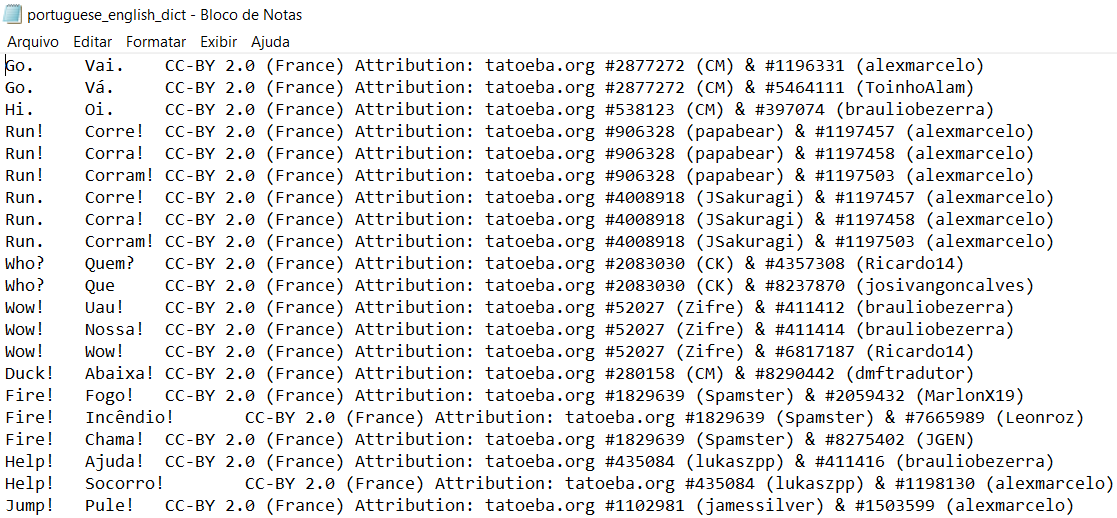

Note que, embora a situação mais comum seja encontrar colunas separadas por vírgulas (CSV) ou por espaçamentos em branco (txt), estes demarcadores não são adequados para este dicionário.

Isso porque o dicionário é composto por frases a serem traduzidas, e as frases já contêm tanto vírgulas quanto espaços em branco.
- Assim, a utilização de tais demarcadores separaria cada frase em múltiplas colunas. 
- Precisamos, portanto, de um demarcador de colunas que não seja encontrado normalmente nas frases, caso da tabulação.

Lembre-se ainda que a tokenização utiliza os espaços em branco da frase para separá-la em tokens (em geral, tokens = palavras, dependendo da estratégia de tokenização).
- A utilização da demarcação incorreta de separação poderia resultar em tokens interpretados como colunas/atributos.

Analisemos, então, o restante do loop:

In [ ]:
#CARREGAR ARQUIVO COM O DICIONÁRIO
#Este arquivo contém frases traduzidas de um idioma para outro, e cuja tradução foi validada.
#Assim, este arquivo possui tanto inputs (frases a serem traduzidas) quanto os targets 
#(tradução que o algoritmo deve aprender)

# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('portuguese_english_dict.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 4000


**ATENÇÃO**

O endereço dos arquivos deve ser inserido com o número correto de espaçamentos. A inclusão de espaços em branco a mais no começo e no fim resultará em erro de processamento.

## **Comando `continue`**

Repare o trecho do código destacado abaixo:

```
  # input and target are separated by tab
  if '\t' not in line:
    continue
```
Este condicional verifica se existe a tabulação separando uma frase de sua tradução.
- Caso esta tabulação não exista, significa que foi realizada uma entrada de uma frase sem a sua correspondente tradução.
- Neste caso, a leitura da sentença faria o algoritmo aprender que a tradução da frase na primeira coluna é uma sentença vazia, o que está errado.
- Assim, para evitar este erro de aprendizado, utilizamos **comando `continue`, que simplesmente avança à próxima iteração sem executar o código restante do loop**.

Desta forma, o comando `continue` faz com que o algoritmo "salte" todas as linhas com entradas sem a correspondente tradução (linhas sem a presença de tabulações separando as colunas). Estas linhas são simplesmente ignoradas no processo de treinamento, de modo que não precisam ser excluídas da base de dados.


# **Método `rstrip()`**

Este método corresponde à função **Trim**, a qual remove as formatações e espaçamentos em branco antes e após uma string ("**trailing spaces**").
- Repare que, uma vez que o tokenizer utiliza os espaços em branco para separar os tokens, a presença destes espaços extras poderia criar uma série de tokens vazios, ou mesmo retornar um erro.

# **Método `split()`**

Este método divide o objeto anterior sempre que encontra a string especificada como argumento.

```
  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')
```
- No caso, o objeto é toda a linha (entrada) após suas três colunas serem submetidas ao método `rstrip()`: `line.rstrip()` (lembrando que esta é a **função Trim**, que elimina espaços brancos extras no começo e ao fim da string).
- Repare que a função Trim é aplicada apenas antes e após todo o texto, de modo que as tabulações delimitadoras de colunas não são apagadas.

Assim, o `split('\t')` separa a linha "trimmed" em cada uma de suas tabulações (string representada pelo caractere especial `'\t'`).

Voltando à imagem anterior que mostra o dicionário, vemos que existem duas tabulações: a primeira separa a sentença do target; e a segunda separa o target da licença de uso.
- Assim, o split separará cada linha em 3 strings: 
 - A primeira é a sentença na língua original, a qual é salva na string `input_text`;
 - A seguinte é a sentença traduzida (target), salva na string `translation`;
 - Por fim, a string `*rest` armazena o restante da linha (licenças de uso), o qual não será utilizado para treinamento do algoritmo.



# **Modificar a ordem de tradução - Realizar tradução oposta**

- O algoritmo é treinado para traduzir de uma primeira língua para uma língua-alvo.
- No presente caso, traduzimos do inglês para o português.

Este algoritmo não é capaz de realizar a tradução oposta, do português para o inglês.
- Contudo, não precisamos de um novo dicionário: podemos utilizar o mesmo arquivo, bastando modificar a ordem com que as sentenças são salvas nas listas correspondentes. Em:

```
# split up the input and translation
input_text, translation, *rest = line.rstrip().split('\t')
```
A primeira sentença será salva na lista `input_text`, enquanto a segunda será salva em `translation`.
- A primeira sentença é a frase em inglês, enquanto a segunda sentença é a frase em português.

### **Para traduzir do português para o inglês, basta que a primeira sentença (inglês) seja salva em `translation`, enquanto a segunda sentença (português) é salva em `input_text`.**
- Para isso, basta inverter a ordem de chamamento das listas:
```
# split up the input and translation
translation, input_text, *rest = line.rstrip().split('\t')
```




### **Alternativa ao método `split`**

Por padrão, a função `pandas.read_csv` reconhece a vírgula como separador de coluna. No caso de se fornecer o argumento `delim_whitespace = True`, o espaço em branco simples é reconhecido como separador de coluna. Além disso, o argumento `header=None` informa à função `pandas.read_csv` que o dataframe não possui cabeçalho.
- Alternativamente, é possível fornecer à função `pandas.read_csv` o argumento `sep='\s+'`, o qual informa que o separador de coluna é o espaço branco. Como este argumento é análogo a `delim_whitespace = True`, apenas um dos dois deve ser fornecido.

Assim, ao invés de utilizar o comando `open`, que abre o arquivo como documento de texto simples, poderíamos utilizar a função:

```
pd.read_csv(caminho_do_arquivo, sep='\t', header=None)
```
A qual interpretaria o arquivo como um dataframe sem cabeçalhos e cujas colunas são separadas por tabulação. A seguir, cada coluna seria simplesmente gravada em uma lista diferente.

# **Restante do loop**

Precisamos acrescentar o token de fim da sentença `<eos>` à sequência de target (sentença traduzida).
- Criamos, então, a string target_text, formada pela concatenação da tradução com um espaço em branco e o token `<eos>`.

```
target_text = translation + ' <eos>'
```


Lembrando a **particularidade do teacher forcing**: os inputs de treinamento e os targets devem ser, na realidade, as mesmas sentenças, mas com um offset de 1.
- Este offset é criado pela simples inclusão do token de início da sentença `<sos>` ao começo da frase.

Assim, para criar a string que será utilizada como input da RNN de treinamento, simplesmente concatenamos o token `<sos>` e um espaço em branco ao começo da sentença original. Essa string é chamada `target_text_input`.

```
 target_text_input = '<sos> ' + translation
```

- Para acompanhar o percurso das sentenças de maneira correta, precisamos incluir o token de começo da sentença `<sos>` à sequência de input; e o token de fim da sentença `<eos>` à sequência de target.
- Mais uma vez, note que existe um espaço em branco nas strings:

```
'<sos> '
' <eos>'
```
- Isto está relacionado ao método de Tokenização, que procura pelos espaços em branco entre as palavras para separar os tokens. Assim, o espaço em `'<sos> '` separa este token da primeira palavra da sequência, enquanto que o espaço em `' <eos>'` separa o último elemento da sequência do token de encerramento.
- Como foi adicionado exatamente um token a cada sentença, as sequências continuam apresentando o mesmo comprimento, como requer o método Keras.


Ao fim, de cada iteração do loop, as três sentenças (sequências de palavras) são gravadas como novos elemento de listas:
- A sentença na língua original (salva na string `input_text`) é adicionada à lista `input_texts` (note a diferença entre o nome da string e da lista);
- A sentença traduzida (target) à qual foi concatenado o token `' <eos>'` (salva na string `target_text`) é adicionada à lista `target_texts`;
- A sentença que será utilizada como input da RNN de treinamento, formada pela concatenação do token `<sos>` e de um espaço em branco ao começo da sentença `target_texts` (salva na string `target_text_input`) é adicionada à lista `target_texts_inputs`.

# **Aplicar o método keras.tokenizer aos inputs para conversão das sentenças em números inteiros**

Esta é mais uma etapa de pré-processamento textual. Note que, até aqui, ainda temos uma lista que lembra uma serra, já que cada sentença ainda apresenta um comprimento diferente.
- Logicamente, a lista ainda é constituída por strings, o que não é processável pelas redes neurais (as redes neurais exigem que as strings sejam convertidas em valores numéricos).
- As strings ainda contêm os comentários completos, ou seja, ainda não foram tokenizadas.
- Devemos aplicar o **método tokenizer da biblioteca keras** para resolver estes problema: o **keras.tokenizer** converte as sentenças em listas de tokens e, a seguir, converte estas listas em números inteiros.
- Estes números inteiros serão usados para indexar o **word embedding** (a matriz contendo os vetores das palavras, na qual cada linha da matriz corresponde ao vetor numérico de uma palavra).

In [ ]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

Repare que o método do ajuste do tokenizer é aplicado somente à lista `input_texts`.

Mais uma vez, o tokenizer divide (split) as sentenças em tokens ou palavras individuais; e converte cada palavra em um índice inteiro a partir do qual a informação poderá ser recuperada pelo mapeamento.

# **Associar cada palavra a uma linha (vetor de palavras) do word embedding**

Agora que as sentenças foram convertidas em números inteiros, surge a pergunta sobre a qual palavra cada número inteiro corresponde.
- Além disso, desejamos saber qual linha do word embedding pertence a cada palavra.
- Lembrando o que é o word embedding: **word embedding é a matriz dos vetores das palavras. Cada linha do word embedding representa o vetor numérico associado a cada palavra**. 
- Indexar aqui significa encontrar o índice do vetor (ou seja a linha do word embedding) que descreve cada uma das palavras tokenizadas.

Para isso, precisamos de um **mapeamento palavra-para-índice** (word to index mapping).
- Neste mapa, a chave (key) será a palavra, e o índice será o valor correspondente.
- **O keras.tokenizer mantém esta informação de mapeamento em um atributo chamado word_index**.

In [ ]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 1029 unique input tokens.


# **Caracterização das sequências de texto obtidas e convertidas em inteiros**

Vamos caracterizar as sentenças, agora que foram tokenizadas e convertidas em números inteiros.

In [ ]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

# **Repetir as etapas anteriores (tokenização, mapeamento e caracterização) para os outputs**

- O algoritmo para tradução lida com dois idiomas diferentes.
- Isto significa que temos 2 vocabulários distintos, um no Encoder (língua original), e outro no Decoder (idioma-alvo).

### **Como temos dois vocabulários, é necessário criar 2 tokenizers, um para cada idioma. O primeiro é aplicado às sentenças do idioma original, o segundo às do idioma target.**

- Isto também leva à necessidade de 2 mapeamentos word2idx distintos, cada um com suas próprias variáveis descritivas (total de palavras e máximo comprimento de sentença).

# **Tokenização**

In [ ]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

Note o seguinte argumento do tokenizer:

```
filters=''
```
### Estamos passando como argumento **filtros constituídos por strings vazias**.
- **Se não fizermos isto, o tokenizer filtrará (removerá) todos os caracteres especiais**.
- **Tanto o token de começo quanto o de fim da sentença contêm caracteres especiais < e >**.
- Assim, sem este argumento, os sinais que delimitam os tokens de início e fim seriam removidos.

No trecho a seguir, vemos que este segundo tokenizer é treinado para as strings concatenadas `target_texts + target_texts_inputs`. A seguir, ele é aplicado individualmente às listas `target_texts` e `target_texts_inputs`.

```
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
```

Retornando ao código de carregamento dos dados:
```
target_text = translation + ' <eos>'
target_text_input = '<sos> ' + translation
```
**Vemos que os tokens `<sos>` e `<eos>` foram adicionados apenas às sequências de target, que vão no decoder**.
- Esta a razão pela qual não precisamos nos preocupar com a eliminação de caracteres especiais nos inputs (encoder).
- Assim, precisamos acrescentar o argumento `filters=''` apenas ao decoder (outputs), que é o sistema que lida com caracteres especiais que não podem ser eliminados.


## **Atenção:**
- Não é necessário alterar nenhum desses passos caso deseje realizar a tradução oposta.
- Basta inverter a ordem com que as sentenças são gravadas nas listas de input e output, como mencionado anteriormente.
- O restante do código é referenciado nestas listas, e não na ordem das sentenças no dicionário.
- Assim, uma vez que as sentenças tenham sido armazenadas nas listas corretas de input e de tradução (de acordo com qual a língua original e qual a língua-alvo), o restante do código já estará apto a realizar a tradução correta.

# **Mapeamento (dicionário word2idx das saídas)**

In [ ]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 2537 unique output tokens.


Este dicionário será responsável por converter os valores numéricos obtidos como saída do decoder em palavras, de modo a gerar as sentenças traduzidas.

# **Caracterização: número de palavras e máximo comprimento de sentença**

- Estas variáveis devem ser calculadas e armazenadas para uso posterior.

In [ ]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [ ]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

# **Limitar comprimento das sequências de texto com o método pad_sequences**

Neste momento, ainda temos um problema com nossos dados: os arrays continuam com tamanhos diferentes, formando um aspecto de serra.

- Para resolver este problema, a próxima etapa de pré-processamento será aplicar o **método pad_sequences**.
- Para o Encoder, o comprimento máximo foi armazenado na variável `max_len_input`, calculada durante a caracterização dos inputs após a tokenização.
- Para o Decoder, o comprimento foi armazenado na variável `max_len_target` durante a caracterização pós-tokenização.
- Estes valores serão aplicados como argumento `maxlen` do método `pad_sequences`.

# **Padding do Encoder**

In [ ]:
## pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

encoder_data.shape: (4000, 4)
encoder_data[0]: [ 0  0  0 14]


# **Padding do Decoder**

In [ ]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

decoder_data[0]: [  2 589   0   0   0   0   0   0   0]
decoder_data.shape: (4000, 9)


Esta etapa é particularmente importante porque a biblioteca **Keras trabalha com sequências de dimensões constantes**.
- O formato do tensor de dados representa a dimensão da matriz (N x T) obtida. 
- Note que, como desejamos que o algoritmo aprenda a traduzir sentenças de diversos comprimentos, não limitamos a `MAX_SEQUENCE_LENGTH = 100` o máximo comprimento da sequência de textos, como feito para o treinamento do encoder.
- N = contagem de elementos;
- T será o máximo comprimento permitido para o vetor de palavras (máximo possível de colunas).

Note que, para que todas as sequências tenham o mesmo comprimento, **caso o vetor tenha um comprimento menor que o informado no argumento `maxlen`, o método pad_sequences adicionará vários números zero ao fim dele** até que ele atinja o comprimento máximo.

Uma questão que surge é como saber se o vetor ao qual foram adicionados os números zero não passou a ser igual a um outro vetor de palavras previamente definido no nosso vocabulário.
- Esta é uma questão válida, já que, ao construir o dicionário que correlaciona as palavras aos índices, nós utilizamos o zero para representar uma das palavras.
- Porém, **neste caso em particular, Keras inicia a indexação pelo número 1, e apenas utiliza o zero como um valor especial reservado para a operação de padding**.
- Desde que você **permaneça no ecossistema Keras durante as etapas de pré-processamento de texto**, a adição dos números zero não será um problema.

# **Argumento `padding='post'`**

No decoder, fornecemos o argumento `padding='post'`, o que significa que o preenchimento por zeros para homogeneizar os comprimentos de sequência (padding) ocorrerá somente ao fim (à direita) do vetor de palavras.
- Isto é exemplificado na seguinte saída impressa como exemplo, na qual os zeros são todos incluídos "à direita" (após) o vetor:

```
decoder_inputs[0]: [   2 1381    0    0    0    0    0    0    0]
```
- **Por padrão, os zeros são acrescentados antes (à esquerda) do vetor de números**. 

Assim, como o argumento `padding` não é fornecido ao encoder, a adição de zeros ao encoder é feita à esquerda, como mostra a seguinte saída de exemplo:

```
encoder_inputs[0]: [ 0  0  0  0 19]
```
- Em última análise, isto não causa grande impacto, pois as operações seguintes constituirão multiplicações por zero. Porém, note que esta diferença na ordem de posicionamento dos zeros faz sentido porque:
  - A saída do Encoder corresponde ao momento em que você vê a última palavra da sentença de input (sentença na língua original) - ela é vista após os zeros, marcando a conclusão da leitura; enquanto que
  - O decoder produz a saída imediatamente após ver o estado do encoder. Primeiro, o decoder emite a sentença traduzida (o que se deseja obter), e depois a completa com os zeros (o decoder primeiro vê a sequência, e não os zeros que a completam e que não representam informação a ser decodificada).

Note ainda que o método **`pad_sequences` deve ser invocado 3 vezes, uma vez para cada um dos arrays** `input_sequences`, `target_sequences`, e `target_sequences_inputs`:

```
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
```

## **Atenção: aplicação do modelo RNN à tradução de sentenças novas, não presentes nos dados de treinamento**
- Em última análise, desejamos que nosso modelo seja aplicável à tradução automática de sentenças, muitas vezes não presentes no dicionário de treinamento.
- Para tal, devemos aplicar todos os métodos de pré-processamento de texto (etapas acima) a estas sentenças.
- As sentenças serão salvas em listas; serão submetidas ao padding para que tenham comprimentos iguais; serão convertidas em vetores numéricos; serão tokenizadas; e deverá haver um mapeamento palavra para índice correspondente.

Neste notebook, as traduções são geradas a partir de sentenças já presentes no dicionário usado para treinamento. 
- Ou seja, serão traduzidas sentenças que já foram pré-processadas pelo código acima.
- É por este motivo que não é acrescentado um conjunto de etapas referentes ao processamento das sentenças que serão traduzidas utilizando-se o modelo obtido.

# **Vamos criar um dicionário vazio, chamado word2vec** 
Este dicionário armazenará os dados já pré-configurados, i.e., palavras que já foram convertidas em vetores numéricos, e que estão disponíveis nas bases glove.6B.

- O comprimento dos vetores de palavras será o definido e armazenado em EMBEDDING_DIM.
- O dicionário possui como estrutura: a palavra como a chave (key); e o vetor de palavras (word vector) como o valor correspondente.
- A nomenclatura word2vec vem de "word pointing to vector".
- Os arquivos glove.6B consistem em txt contendo a cada linha uma palavra seguida dos valores das componentes dos vetores, separados por espaços em branco.
- Assim, nós: 1) carregamos uma linha; 2) dividimos (split) as linhas em tokens; 3) tomamos o primeiro token como sendo a palavra; 4) tomamos os demais tokens como o vetor; 5) convertemos o vetor em um NumPy array; 6) e, por fim, salvamos cada array no nosso dicionário.

In [ ]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


Não imprima o dicionário word2vec! Devido ao seu tamanho elevado, sobrecarregará a visualização do notebook.

Note que ainda não começamos o treinamento das RNNs. O que fizemos aqui foi abrir uma série de arquivos de texto previamente carregados no Google Drive (arquivos contendo dados pré-treinados de palavras convertidas em vetores numéricos). Após abri-los com o comando with open, manipulamos as strings para que os dados povoassem um dicionário vazio.

Caso estivesse usando um ambiente offline, e não o Google Colab, o seguinte código deveria ser utilizado:

```
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))
```



Note que o trecho `glove.6B.%sd.txt' % EMBEDDING_DIM`

faz com que todos os arquivos com o número %s = EMBEDDING_DIM sejam lidos.


# **Pré-carregar a matriz de incorporação ("embedding matrix") que será utilizada pela rede neural**

No começo deste notebook, carregamos vetores de palavras previamente definidos, contidos no arquivo glove.

- A primeira coisa a fazer agora é verificar o número de palavras que será realmente utilizado como vocabulário da rede neural.

Este valor é simplesmente o mínimo entre `MAX_NUM_WORDS = 20000`, e o **comprimento (total de palavras) do dicionário** palavra-para-índice ("*word to index dictionary*") **somado a 1**.

Explicação:
- Lembre-se que definimos nos parâmetros de configuração inicial:
```
MAX_NUM_WORDS = 20000
```

- Entretanto, o número de palavras no dataset pode ser menor que 20.000. Neste caso, nós não queremos que sejam criados 20.000 vetores de palavras, mas sim o **menor número possível de vetores** (ou seja, armazenaremos menos que 20000 palavras).

- Por sua vez, o número de palavras pode ser superior a 20000. Nesta situação, **desejamos truncar os dados (o vocabulário) para que reste apenas `MAX_NUM_WORDS = 20000 vetores`**.

In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)

Filling pre-trained embeddings...


O trecho acima:

1) Verifica o total de vetores de palavras presente no vocabulário (o comprimento/dimensão do dicionário);

2) Compara este valor com `MAX_NUM_WORDS`.
- Se o tamanho do vocabulário for menor que `MAX_NUM_WORDS`, então a variável `num_words` é igualada ao tamanho do dicionário + 1 para que possamos trabalhar com o menor número possível de vetores de palavras (i.e., com menos palavras);
- Se a dimensão for maior que `MAX_NUM_WORDS`, truncamos o vocabulário de modo que ele terá apenas `MAX_NUM_WORDS = 20000` palavras.
  - Para isso, igualamos a variável `num_words` a `MAX_NUM_WORDS`.

Note que **precisamos somar 1** em

```
num_words = min(MAX_NUM_WORDS, len(word2idx) + 1)
```
**Porque, como visto, a biblioteca Keras inicia a indexação dos vetores de palavras em 1**, reservando o valor zero para as operações de padding.

Assim, se tivermos 20000 palavras, o índice da última palavra será efetivamente 20000, e não 19999 (índice esperado se a numeração começasse em zero, como comumente ocorre com as listas em Python).

Assim, caso deseje utilizar o índice para indexar um array, é necessário acrescentar um elemento. Isso porque, em Python, a numeração dos elementos dos arrays, assim como das listas, começa em zero.


Outra questão que pode surgir é: uma vez que tomamos o mínimo entre 20000 e o tamanho do vocabulário, o que ocorrerá se houver índices no array de dados maiores que 20000?

De fato, caso tente indexar um array por um número maior ou igual ao seu comprimento, o resultado será uma exceção ("*exception error*").

Felizmente, esta questão já foi resolvida anteriormente durante a criação do tokenizer:
```
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
```
Como utilizamos MAX_NUM_WORDS como um dos argumentos do método Tokenizer, **Keras já definiu que estes índices, caso existam, estarão fora dos tokens do vocabulário**.

- OBS: comumente encontramos estas situações que foram assinaladas como fora dos tokens referenciadas pela abreviatura **OOV** ("*out of vocabulary*").
- Outra abreviação comumente encontrada em comentários de códigos é **UNK, referente a unknown**.

# **Criação da matriz embedding**

A última etapa do pré-processamento do texto consiste em criar uma matriz V x D de zeros, que será o **embedding**. V é simplesmente o número de palavras `num_words`, o qual já calculamos, e D é a dimensão do embedding, `EMBEDDING_DIM`.

A seguir, criamos um loop para avaliar cada palavra do dicionário palavras-para-índices ("word to index dictionary").

- **Se o índice for menor que o MAX_NUM_WORDS** (já corrigido para o caso de haver menos palavras que o definido nos parâmetros), **então ele deverá estar no embedding**.
- Esta etapa consiste, então, em uma tentativa de recuperar o vetor de palavras pré-treinado do dicionário de palavras.
- Lembre-se que os **vetores de palavras pré-configurados vêm de uma fonte (arquivos glove) diferente da fonte dos comentários classificados como tóxicos e utilizados como dados de treinamento** (arquivo train.csv). 
- Como os dados de treinamento é que são utilizados para construir o dicionário, **é possível que determinados vetores de palavras pré-treinados não sejam encontrados no dicionário** (as duas fontes de dados, glove e train, não são necessariamente equivalentes).



In [ ]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Repare que utilizamos o método **get** em:

```
word2vec.get(word)
```
Caso a chave (key) correspondente a um dos vetores de palavras pré-configurados não seja encontrada no dicionário (ou seja, caso aquela palavra não esteja presente no vocabulário de treinamento), **o método get simplesmente retorna um valor nulo como chave do dicionário, ao invés de gerar uma exceção, como ocorreria ao se tentar indexar um array ou lista**.

- O trecho acima também verifica, na sequência, se o vetor é nulo, em:
```
 if embedding_vector is not None:
```
- Caso o vetor não seja nulo, ele é assinalado à matriz de embedding na localização apropriada.



# **Criação de versão one-hot dos targets**

A função de "sparse cross-entropy" de Keras não funcionará se o input for uma sequência.
- Isto não era problema nos exemplos anteriores porque possuíamos apenas um target por input.
- Porém, agora **temos dois targets por input: cada amostra nos fornece uma sequência completa de targets**.

Como a "sparse cross-entropy" não foi projetada para este caso, é possível construir a própria função de perda.

Criação da matriz de one-hot encoding, inicialmente nula:

In [ ]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

Assinalar valores 1 aos elementos especificados:

In [ ]:
# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word > 0:
      decoder_targets_one_hot[i, t, word] = 1

Note que primeiro criamos uma matriz apenas com elementos nulos (np.zeros).
- A seguir, fornecemos o valor 1 apenas aos elementos especificados, de modo a diferenciá-los uns dos outros (ou seja, de modo a realizar o encoding destes elementos).

# **Método enumerate**

Cria uma numeração correspondente ao índice de uma lista. Como padrão do Python, **a indexação começa a partir de 0**. Porém, podemos passar o valor inicial da numeração como argumento do método, o que permite começar em 1. Exemplos:


```
>>> values = ["a", "b", "c"]

>>> for value in values:
...     print(value)
...
a
b
c

>>> for index in range(len(values)):
...     value = values[index]
...     print(index, value)
...
0 a
1 b
2 c

>>> for count, value in enumerate(values):
...     print(count, value)
...
0 a
1 b
2 c

>>> for count, value in enumerate(values, start=1):
...     print(count, value)
...
1 a
2 b
3 c
```



# **Construção e avaliação da RNN**

As etapas anteriores constituíram o pré-processamento do texto necessário à construção do modelo de redes neurais.

Estas etapas constituem cerca de 90% do código do notebook, e **muitas delas são genéricas e aplicáveis a diversos exemplos de NLP**.

# **Criação da camada de embedding**

A criação da camada de embedding consiste em simplesmente criar um objeto do tipo "**Embedding**".

In [ ]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

Os dois primeiros argumentos para construção da camada de embedding são o total de palavras "**`num_words`**" (tamanho do vocabulário); e a dimensão do embedding "`EMBEDDING_DIM`".

- A seguir, vem o argumento **"`weights`"**: nós passamos como argumento justamente **a matriz de embedding que construímos nas etapas anteriores**.
- O argumento **"`input_length`"** informa ao objeto embedding **quão longas nossas sequências serão. Este valor foi fornecido para o encoder (inputs) em `max_len_input`**.
- No último argumento ("**`trainable`**") fornecemos o valor booleano **`False` pois não desejamos que os pesos sejam atualizados durante o procedimento de treino (estamos utilizando vetores pré-treinados** da base glove.6B).
- Logicamente, é permitido realizar a atualização por meio da modificação do parâmetro para `True`. Porém, isto representará maior custo computacional e, possivelmente, um tempo longo de treinamento.
  - Considerando o quão complexa já é a arquitetura do modelo de atenção e o elevado custo computacional demandado por esta arquitetura, este tipo de alteração pode impedir o processamento do modelo.

# **Construção do restante do modelo de redes neurais recorrentes (RNNs)**

Temos aqui um tensor de dados (variável "data") constituído pelos comentários a serem classificados. É uma matriz N x T contendo os índices das palavras, na qual N é o total de amostras/dados e T é o comprimento da sequência.
- Além disso, temos a matriz de embedding, de dimensão V x D, à qual já assinalamos alguns vetores de palavras. V é o tamanho do vocabulário e D é a dimensão do embedding.


Para construção da rede neural em Keras, o primeiro requisito é criar o objeto de input.

- Devemos especificar cada uma das dimensões, exceto o tamanho da amostra, o qual já está implícito.
- Como visto, o input usará como argumento um tensor de dados de dimensão N x T, onde N = contagem de elementos (tamanho de amostra, implícito), e T = máximo comprimento permitido para o vetor de palavras = **`max_len_input`**.
- Assim, precisamos apenas fornecer `T = max_len_input` como argumento de criação do objeto de input.

A seguir, utilizamos este input como argumento da camada de embedding que criamos a pouco.

In [ ]:
##### build the model #####

# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,
  # dropout=0.5 # dropout not available on gpu
))
encoder_outputs = encoder(x)

# **Unidade recursiva: LSTM bidirecional**

- Após passar pela camada de embedding (assim como ocorre com as CNNs), os inputs têm de passar pela unidade recursiva.

- Aqui, especificamos a unidade recursiva como LSTM bidirecional: `Bidirectional(LSTM())`.
- Repare que definimos `return_sequences = True`, de modo que os hidden states h serão retornados.

Neste modelo, o encoder é relativamente simples.
- A etapa mais complexa é a construção do decoder.

# **Criação do Decoder**
A primeira etapa de configuração do decoder consiste em criar os target inputs, i.e., os inputs para o teacher forcing.
- Lembrando: no teacher forcing passamos como input a palavra correta que deveria ser gerada (i.e., a tradução correta já validada), com um offset de uma unidade que impede que a LSTM do decoder aprenda a simplesmente copiar a palavra de input como saída.

Estes valores são passados por uma camada de embedding própria, assim como ocorre no Seq2Seq convencional:

```
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
```



In [ ]:
# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# **Criação do mecanismo de atenção**

A etapa seguinte consiste na criação do mecanismo de atenção propriamente dito.
- É necessário calcular o vetor de contexto várias vezes, o que significa que deveríamos colocá-lo em uma função.
- Desejamos que esta função utiliza os mesmos pesos em todas as vezes.
  - Para isso, devemos criar camadas de redes neurais globais, de modo que possamos utilizar sempre as mesmas camadas a cada loop da função.

Na rede neural a seguir, utilizamos duas camadas densas: 
- A primeira delas é ativada pela tangente hiperbólica, `tanh`;
- A segunda é ativada pela função `softmax_over_time`, definida no início deste notebook.
- Por fim, é calculado o produto escalar (dot product) entre os pesos de atenção α e os hidden states h, como explicado acima.

In [ ]:
######### Attention #########
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)

attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

# **Função para avaliação do vetor de contexto múltiplas vezes**
- O mecanismo de atenção é atenção é colocado em uma função porque precisamos repeti-lo diversas vezes.
- Como mencionado, devemos usar os mesmos pesos todas as vezes, e por isso as funções são definidas de forma global. 
- Isto garante que possamos usar sempre as mesmas camadas sempre que chamarmos uma função.

A função `one_step_attention`executa os procedimentos teóricos do início deste notebook:

1) Copia os hidden states s(t-1) da LSTM anterior do decoder em cada um dos pesos α. Estes hidden states são repetidos Tx vezes:
```
# copy s(t-1) Tx times
# now shape = (Tx, LATENT_DIM_DECODER)
st_1 = attn_repeat_layer(st_1)
```
Como discutido na etapa teórica, a dimensão do vetor s(t-1) é M2.
- Após a repetição dele por Tx vezes, a dimensão passa a ser Tx x M2.
- Com isso, o vetor passa a ter a dimensão correta (Tx x M2) para ser concatenado a h.

2) Concatenação do vetor anterior a h:
```
# Concatenate all h(t)'s with s(t-1)
# Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
x = attn_concat_layer([h, st_1])
```
Note que o formato do vetor h, antes da concatenação, é Tx x 2M1.
- Este vetor é concatenado a st_1 (vetor com os valores de hidden states s(t-1) repetidos). Neste momento, st_1 tem dimensão Tx x M2.
- Após a concatenação, o vetor concatenado apresenta dimensões Tx x M2 + 2M1.

3) Estes dados são passados pelas duas camadas densas da rede neural responsável pelo cálculo dos pesos de atenção α:
```
# Neural net first layer
x = attn_dense1(x)
# Neural net second layer with special softmax over time
alphas = attn_dense2(x)
```
- Como a função `softmax_over_time` já foi incluída anteriormente na configuração desta camada densa, ela não precisa ser especificada manualmente.

4) O passo final para obtenção do vetor de contexto é o cálculo do produto escalar (dot product) entre os valores de α e os hidden states h originais:
```
# "Dot" the alphas and the h's
# Remember a.dot(b) = sum over a[t] * b[t]
context = attn_dot([alphas, h])

return context
```
Lembrando que o produto escalar consiste na soma de cada um dos produtos α(t) x h(t).
- Esta operação encerra o mecanismo de atenção.
- Após realizar esta operação, a função retorna o vetor de contexto (`context`) que será usado como input da LSTM do decoder.

In [ ]:
def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context

Note que a função `one_step_attention` evoca as camadas definidas anteriormente para a rede neural responsável pelo cálculo dos pesos de atenção: `attn_repeat_layer`; `attn_concat_layer`; `attn_dense1`; e `attn_dense2`.
- Como estas camadas foram definidas de forma global, a função consegue evocá-las e pode utilizar sempre as mesmas configurações de redes neurais.
- No caso da segunda camada densa, isso faz com que não precisemos nos preocupar com o uso da função `softmax_over_time`, já que ela já foi especificada nas configurações originais da camada.
- O uso da função permite que a operação seja realizada seguidas vezes, possibilitando o cálculo dos pesos de atenção e a obtenção do vetor de contexto.

# **Decoder**

As duas últimas camadas são referentes ao Decoder: 
- A primeira delas é a LSTM do decoder, que utiliza como inputs: o hidden state s(t-1) da LSTM anterior do decoder; e o vetor de contexto.
- A camada seguinte é uma camada densa, a qual nos fornece a probabilidade de a palavra seguinte ser gerada.

In [ ]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

# **Variável simbólica de saída**

Agora é preciso utilizar todas as funções e camadas criadas para obter uma variável simbólica de saída. Para isso, precisamos definir novos inputs: os estados iniciais (hidden state s0 e cell state c0).

Na sequência, passamos estes estados iniciais por uma nova camada de concatenação.

**É esta camada de concatenação que será utilizada para o teacher forcing.**

A camada de concatenação combinará a palavra correta que deveria ter sido gerada pela LSTM anterior com o vetor de contexto. 
- Lembrando: é a palavra anterior que será utilizada, porque há um offset de 1 unidade para que a LSTM não aprenda a simplesmente copiar a entrada na saída.

In [ ]:
initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

# **Loop por cada instante Ty (Decoder)**

Como discutido na seção teórica deste notebook, o loop deve percorrer cada um dos instantes possíveis da LSTM do encoder:
- Os hidden states h do encoder são avaliados tanto no sentido direto quanto no reverso (LSTMs bidirecionais). Ignoramos por completo os cell states de encoding.
- Os hidden states h(1), h(2), ..., h(t'), ..., h(Tₓ) resultantes das LSTMs bidirecionais do encoder são concatenados ao hidden state s(t-1) do decoder. O hidden state s(t-1) é repetido (copiado) para todos os valores h(t').
- Assim, para cada valor t = 1, 2, ..., t, ..., Tₓ, teremos um total de Tₓ vetores concatenados [s(t-1), h(t')].
- Isto deve ser repetido para cada uma das Ty iterações da RNN de decoding, de modo que utilizaremos todos os s(t-1) possíveis.

Desta forma, o próximo loop será executado por um número Ty de vezes.
- **As saídas deste loop serão armazenadas em uma lista chamada `outputs`.**


In [ ]:
# Unlike previous seq2seq, we cannot get the output
# all in one step
# Instead we need to do Ty steps
# And in each of those steps, we need to consider
# all Tx h's

# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []

## **1. Obtenção do contexto**

- Obter o vetor de contexto significa executar a função `one_step_attention` definida anteriormente.
  - Os inputs desta função `one_step_attention` são os estados do encoder, juntamente ao estado anterior do decoder s(t-1). 
  - Os estados h(t) são concatenados a s(t-1), como visto.

## **2. Passar os valores de target**
- Os valores de target (palavra correta já traduzida - tradução já validada) devem ser passados para o teacher forcing.
- Neste momento, passamos a sequência completa (sentença completamente traduzida) de uma única vez.
- Assim, a sentença de input efetivamente representa a tradução completa da sequência.
- Porém, nós **não desejamos concatenar o contexto à sentença de input completa.**
  - Nós desejamos somente a palavra anterior correta que deveria ter sido gerada ("previous correct word"). Lembre-se que existe um offset de uma unidade.
  - O decoder gera uma palavra da sequência de saída (tradução) por vez. 
  - Assim, para o instante t, a LSTM do decoder deve ser alimentada com a palavra correta que deveria ser gerada em t-1 (o t-1 ésimo elemento da sentença de saída).
  - Existe, portanto, a necessidade de selecionar a fatia correta do tensor que representa as sentenças de input traduzidas (traduções validadas).
  - Naturalmente, isso corresponde ao índice t.

Esta segunda etapa é realizada por meio de sintaxe NumPy simples, utilizando a notação ":,". 
- Esta notação representa a seleção de todas as linhas, e apenas a coluna à direita da vírgula (ou seja, a seleção da coluna completa).
 - [:, 2] - todas as linhas da coluna 2. Por sua vez:
 - [2, :] - todas as colunas da linha 2 (lembrando que a numeração começa em zero).

Isto é feito em:
```
selector = Lambda(lambda x: x[:, t:t+1])
xt = selector(decoder_inputs_x)
```
Lembrando que a **primeira dimensão é o total de amostras, e precisamos selecionar todas as amostras** (razão pela qual a primeira dimensão é substituída pelos 2 pontos).

Já a segunda dimensão é o tempo.
- Naturalmente, **o tempo correspondente à t-ésima iteração do loop é o próprio t.**


In [ ]:
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

### **Atenção: toda operação em uma rede neural Keras deve ser uma camada da rede neural.**
- Por isso, devemos juntar tudo em uma camada Lambda. 
- Esta camada foi importada diretamente das camadas pré-configuradas de Keras em:
```
from keras.layers import Lambda
```
Importante: note que **esta camada não deve ser uma variável global.**
- Isto porque precisamos que cada camada indexe um valor diferente no tempo (um elemento distinto da sequência textual).

## **3. Combinar xt com o contexto**
Agora que obtivemos xt, podemos combiná-lo ao contexto utilizando a camada de concatenação definida anteriormente:
```
# combine 
decoder_lstm_input = context_last_word_concat_layer([context, xt])
```
Com isto, completamos os inputs da LSTM.

## **4. Alimentar a LSTM do decoder**
A camada de concatenação fornece como saída os inputs para a LSTM do encoder.
- Podemos finalmente invocar a LSTM do decoder, utilizando os inputs obtidos como alimentação da camada:
```
# pass the combined [context, last word] into the LSTM
# along with [s, c]
# get the new [s, c] and output
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])
```
Repare na linha acima que os estados s (hidden state) e c (Cell state) do decoder são passados como estados iniciais em `initial_state=[s, c]`, e esta operação retorna novos valores s e c.
- Estes novos valores serão usados como alimentação na iteração seguinte.
- Tudo isto é fornecido na mesma linha de código.

Em geral, as camadas LSTM realizam estas operações internamente.
- Porém, aqui **precisamos executar o loop manualmente para poder calcular o contexto** (o que não seria possível na execução automática padrão das LSTMs).

## **5. Última camada densa**
- Passamos a saída da última LSTM por uma camada densa, completamente conectada (Rede neural convencional).
- Esta camada é que gerará a previsão final, i.e., a palavra traduzida (ou a resposta de um chatbot, caso fosse esta a aplicação do algoritmo).
```
# final dense layer to get next word prediction
decoder_outputs = decoder_dense(o)
outputs.append(decoder_outputs)
```
Uma vez obtida a saída (palavra gerada traduzida ou palavra da sentença de resposta do chatbot):
- A saída é adicionada (apêndice) à lista `outputs` que armazena a sequência de saída.

# **Camada Lambda - Lambda Layer**

A camada Lambda agrega expressões arbitrárias em um objeto do tipo Layer (camadas das redes neurais Keras).
- Não podemos simplesmente chamar funções nos modelos sequenciais.
- Nos modelos sequenciais, tudo precisa estar em forma de camadas.
- As camadas Lambda existem para que possamos invocar expressões arbitrárias quando utilizando o modelo sequencial de Keras.

### **Em outras palavras: a camada Lambda converte uma função ou expressão arbitrária passada como argumento em uma camada da rede neural.**
- Uma vez que a função foi convertida em uma camada por meio da camada Lambda, ela pode ser adicionada ao modelo sequencial, e pode ser treinada junto com toda a rede neural.

# **Função `stack_and_transpose`**
- Uma lista Python pode ser contextualizada como um array ou um tensor de dados.
- Se a função `stack`for utilizada sobre uma lista, retornará um tensor.

Dimensão desta lista:
- O loop foi executado Ty vezes. Logo, o comprimento da lista de saída é Ty.
- Cada elemento da lista é N x D.
  - N = batch size;
  - D = output vocab size.

Ao empilharmos todos estes elementos (stack), obtemos um objeto de dimensão Ty x N x D.


In [ ]:
def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  
  return x

O fato de o objeto retornado ser de dimensões Ty x N x D é um problema, pois N deve vir antes (de acordo com as dimensões da rede neural).
- Assim, não podemos simplesmente empilhar (stack) o objeto anterior à rede neural construída.

Assim, além da operação de "stack", precisamos adicionar a transposição.
- É a transposição que fará com que a dimensão N seja a primeira dimensão do tensor; e tornará a dimensão Ty a segunda dimensão do tensor.
- Isto é feito em:
```
x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
```
- Por fim, não é possível simplesmente criar funções em uma rede neural Keras. **Todas as funções devem ser convertidas em camadas da rede neural.**
- Assim, o passo seguinte consiste em criar uma camada `Lambda` a partir da função `stack_and_transpose`; e passar a lista de outputs pela camada.
  - Isto retornará as saídas finais com as dimensões corretas.

In [ ]:
# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

# **Criação de um objeto do modelo ("model object")**

Agora que concluímos a construção do modelo, podemos assinalar ele a um objeto que armazenará as suas principais informações.

- **A função construtora ("constructor") deste objeto utiliza como primeiro argumento o input, e a saída ("output") como segundo argumento**.
- Vamos utilizar as funções e camadas definidas anteriormente para construir um modelo capaz de realizar previsões.

In [ ]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

Note que o objeto que armazena o modelo foi denominado "model".

### Mais uma vez, repare que além da sequência de input (`input_`), o hidden state (`initial_h`) e o cell state (`initial_c`) são utilizados como argumentos de entrada. Ja a saída do modelo estará, conforme os casos anteriores, em `output`.

## **NOTA: A conjunção dos sistemas de encoding e decoding acima constitui apenas 1 dos 2 modelos que precisamos construir. O modelo construído até aqui é utilizado para treinamento, mas não serve para a previsão.**
- Isto porque, como visto, no treinamento podemos utilizar o teacher forcing, mas na previsão precisamos trabalhar com sequências de tamanho unitário, utilizando a saída de um LSTM como entrada do LSTM seguinte.

Além disso, criamos embeddings diferentes para o encoder e para o decoder. **Repare que, no decoder (idioma-alvo) não utilizamos uma camada de embedding (embedding layer) com matriz de embedding já treinada**, como feito no encoder.
- Havendo dados de word embeddings disponíveis, isto poderia também ser feito.

# **Compilar o modelo para treinamento**

Neste exemplo, utilizamos uma função de perda definida pelo usuário, a qual denominamos `custom_loss`.

- Em "optimizer", utilizamos `adam` (escolha arbitrária). As outras opções disponíveis podem ser utilizadas aqui.

- Desejamos saber a precisão do modelo enquanto o treinamos. Para isso, passamos "accuracy" como parâmetro de compilamento do modelo.
  - Neste caso, utilizamos uma versão modificada da precisão, por meio da função `acc` definida pelo usuário.


# **Função de perda e métrica de precisão**

Como visto, podemos definir funções de perda e de precisão adaptadas para o caso particular, como feito a seguir.
- Uma vez definidas estas funções, elas podem ser evocadas normalmente pelo processo de treinamento.



In [ ]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)

In [ ]:
def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

Abaixo, as funções definidas são evocadas em:

```
loss=custom_loss, 
    metrics=[acc]
    )
```

### **Nos comentários do código abaixo está incluído o comando alternativo que utiliza a `'categorical_crossentropy'` e a função `'accuracy'` padrão de Keras.**
- Basta comentar o código e remover os sinais de comentário # do trecho abaixo para utilizar as funções padrão.
- Naturalmente, é possível decidir entre os otimizadores `'adam'`, `'rmsprop'` ou os demais disponíveis.

In [ ]:
# compile the model
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# train the model
z = np.zeros((len(encoder_inputs), LATENT_DIM_DECODER)) # initial [s, c]

É importante que seja possível monitorar o que são os inputs e targets quando chamamos o ajuste (fit) do modelo.
- Os inputs são as sentenças originais em inglês e as correspondentes traduções para o idioma-alvo (português) que são processadas pelo **Encoder**.
  - **Os inputs começam com o token `<sos>` no começo da sentença**.
- Como visto, **os outputs, saídas do Decoder**, são as previsões do modelo e os targets (sentenças traduzidas, com tradução validada) utilizados para o teacher forcing.
  - Como precisamos de um offset de uma unidade, os targets usados como alimentação do decoder são as traduções verdadeiras sem o token `<sos>`, mas **com o token `<eos>` ao fim**.




# **Treinar o modelo**

- Utilizamos o método **.fit** para treinar o modelo.
- **O histórico de treinamento do modelo, incluindo as métricas obtidas, ficará armazenado no dicionário r** definido a seguir.

**Treinar o modelo de linguagem é igual a treinar o modelo Seq2Seq por teacher forcing**.

Com relação à realização de previsões, a geração de uma sentença traduzida utilizando o modelo Seq2Seq utiliza o mesmo processo aplicado à geração de poemas com o Language Model.

- Em tradução, desejamos realizar previsões corretas e exatas, de modo que sempre utilizaremos os máximos de probabilidade.
- Já em poesia, desejamos certo fator de aleatoriedade, de tal forma que as linhas sejam diferentes umas das outras.
- Assim, no Language Model, ao invés de tomar uma previsão exata, tomamos um elemento ao acaso da distribuição de probabilidades obtida como saída do modelo.

No trecho a seguir, o modelo é representado por `model`. 
- `r` representa um dicionário contendo diversas informações históricas a respeito do processo de treinamento do modelo.

Veja também que o hidden state e o cell state iniciais utilizados no processo de treinamento são dados por z. Na linha

```
z = np.zeros((len(input_sequences), LATENT_DIM))
```
Vemos que estes **valores iniciais são tomados arbitrariamente como sendo iguais a zero (criamos z como uma matriz nula)**.

### Como visto, esta é uma diferença importante entre o Language Modelling e o Seq2Seq: **em Language Modelling, tomamos arbitrariamente os estados iniciais como sendo iguais a zero, tanto no encoder quanto no decoder.** Já no Seq2Seq tradicional, os estados iniciais do decoder são iguais aos estados de saída do encoder. Esta situação é novamente modificada em atenção, já que as LSTMs do decoder agora serão alimentadas com o vetor de contexto e com os hidden states da LSTM anterior do decoder.

In [ ]:
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

Epoch 1/30
50/50 [==============================] - 40s 494ms/step - loss: 5.5937 - acc: 0.3143 - val_loss: 5.4926 - val_acc: 0.3002
Epoch 2/30
50/50 [==============================] - 19s 388ms/step - loss: 4.6753 - acc: 0.3472 - val_loss: 5.3539 - val_acc: 0.3015
Epoch 3/30
50/50 [==============================] - 20s 394ms/step - loss: 4.4087 - acc: 0.3602 - val_loss: 5.2960 - val_acc: 0.3162
Epoch 4/30
50/50 [==============================] - 20s 398ms/step - loss: 4.1328 - acc: 0.3825 - val_loss: 5.2331 - val_acc: 0.3266
Epoch 5/30
50/50 [==============================] - 19s 383ms/step - loss: 3.8367 - acc: 0.4037 - val_loss: 5.1264 - val_acc: 0.3547
Epoch 6/30
50/50 [==============================] - 19s 378ms/step - loss: 3.5577 - acc: 0.4277 - val_loss: 5.0816 - val_acc: 0.3832
Epoch 7/30
50/50 [==============================] - 21s 416ms/step - loss: 3.3012 - acc: 0.4476 - val_loss: 5.0767 - val_acc: 0.4008
Epoch 8/30
50/50 [==============================] - 19s 382ms/step - 

### Acima, **nota-se que o treinamento de uma rede neural recorrente é muito mais lento que o de uma rede neural convolucional**.

- Isto ocorre devido ao elevado número de parâmetros da LSTM, o que resulta em quantidade elevada de cálculos a serem realizados em cada epoch.
- A época corresponde a um ciclo (iteração) de treinamento.

## **Até aqui, o que fizemos foi criar e treinar o Seq2Seq model**

Este modelo permite a nós "prever" (ou traduzir) a próxima palavra de uma frase, dado um conjunto de valores iniciais. Desta forma, o próprio modelo aprende a traduzir de uma língua para outra, mesmo quando varia a quantidade de palavras e a pontuação.
- Novamente, precisamos inverter a ordem de treinamento caso desejemos que o modelo faça a tradução reversa.
- Esta rede neural realiza a tradução apenas do Inglês para o Português.

# **Salvar modelo treinado no Google Drive para re-importá-lo futuramente (ou baixá-lo no ambiente offline)**

Aqui, forneça o mesmo endereço da pasta na qual os arquivos das bases de dados foram salvos. Assim, o modelo ficará salvo na mesma pasta, facilitando sua localização.

In [ ]:
folder_adress = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 6 - Attention/"

In [ ]:
from keras.models import load_model
#Definicao do endereço e nome do novo arquivo:

file_address = folder_adress + "rnn1_attention_obtained_model"

#Como utilizamos um modelo com uma função definida pelo usuário (softmax_over_time)
# Precisamos salvar o arquivo sem a extensão .h5.
# Da mesma forma, o modelo será carregado a partir de um objeto sem extensão definida.
#Isto eleva muito o total de memória (peso) necessário para salvar o modelo.

#file_address armazena o local em que sera salvo o modelo: o endereço da pasta foi concatenado
#ao nome e extensão desejados para o arquivo.
#note que o arquivo gerado se chama obtained_model.h5
#Em Keras, os modelos devem ser salvos com a extensão h5.
#h5 é a extensão dos arquivos Hierarchical Data Format (HDF)

#Salvar modelo
model.save(file_address)


#Modelos Scikit-learn: use o modelo da biblioteca dill:
#import dill
#dill.dump(model, open(file_address, 'wb'))
#Nosso modelo foi gerado com a denominação "model", como vimos acima.
#aqui, modifique "model" pelo nome do modelo declarado, caso seja outro o nome utilizado
#note que o arquivo gerado se chama obtained_model.dill
#o dill permite salvar em qualquer extensao (pkl, sav, pmml, ...)

# **Reimportar modelo pré-treinado**

Para reimportar o modelo, basta seguir o código abaixo (ajuste-o de acordo com a pasta do drive na qual está salvo o modelo obtido anteriormente) - basta substituir o valor de "file_address" pelo endereço correto

In [ ]:
from keras.models import load_model
file_address = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 6 - Attention/"
file_address = file_address + "rnn1_attention_obtained_model"

#Aqui, novamente o objeto é chamado sem a extensão h5 para possibilitar que salvemos um modelo contendo função definida
#pelo usuário, softmax_over_time.
model = load_model(file_address)


#Em Sckit-learn
#import dill
#loaded_model = dill.load(open(file_address, 'rb'))
#Agora o modelo carregado  recebe o nome de loaded_model
#todos os campos que recebiam o nome do modelo devem ter o nome substituído para loaded_model
#você também pode modificar o nome loaded_model para um nome de seu interesse. Por exemplo:
#model = dill.load(open(file_address, 'rb')) fará o modelo ser carregado com o nome model

#ATENÇÃO: Caso já haja um modelo 1 com o nome escolhido para carregar este modelo 2, o modelo 1 deixará de existir, 
#sendo substituído pelo modelo 2 carregado.

# **Plotar gráfico da função de perda**

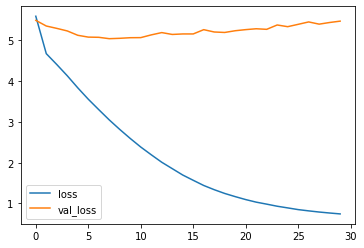

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

O descolamento das curvas indica certo grau de overfitting do modelo.
- Isto pode ter sido causado por um número reduzido de dados de treinamento, já que limitamos as amostras pela definição do hiperparâmetro `NUM_SAMPLES = 4000`.
- O valor sugerido `NUM_SAMPLES = 20000` exige uma disponibilidade de memória e recursos computacionais muito superior à do ambiente AWS SageMaker Data Science.

## **ATENÇÃO: O primeiro teste de validação de um modelo Machine Learning é a verificação da sua capacidade de realizar sobreajuste.**

### **Um modelo que não é capaz de realizar sobreajuste (memorização) em geral não possui complexidade suficiente para representar os dados, resultando no problema oposto (subajuste, underfitting).** 

- Após a verificação da possibilidade de sobreajuste, devemos refinar o modelo para eliminar o overfitting.
- Assim, neste caso, **o overfitting é positivo em um primeiro momento por demonstrar a viabilidade do modelo proposto e comprovar a possibilidade de realizar traduções**.

# **Plotar gráfico da precisão**

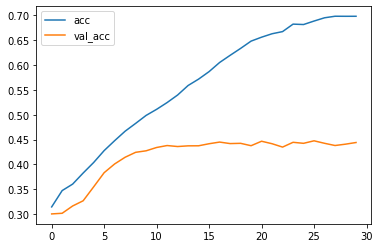

In [ ]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# **Utilização do modelo para realizar tradução**

# **Construção do segundo modelo para o decoder**

Em Keras, precisamos especificar também os comprimentos das sequências ou séries temporais.
- Para o treinamento, o tamanho do input será simplesmente o comprimento da sequência mais longa a ser processada.
  - No treinamento (sistema encoder), nós alimentamos a rede com a sequência de input (frase) completa, e obtemos uma previsão para a palavra seguinte - tudo isto ocorre simultaneamente.
- Para os testes e previsões (sistema decoder), o tamanho do input é diferente. Nós só podemos passar uma palavra por vez, pois precisamos usar cada previsão como input da unidade recursiva seguinte.
  - Precisamos, então, construir um novo modelo, com novas entradas e novos tamanhos.
  - Chamaremos os dois modelos de `encoder_model` e `decoder_model`.

## `encoder_model`
- O encoder_model consiste somente na linha a seguir.
- Nós já definimos as entradas e saídas deste modelo anteriormente, de modo que apenas as aplicamos ao modelo `Model`treinado.

In [ ]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

## `decoder_model`
- O modelo do decoder também é essencialmente repetição do trabalho mais difícil realizado anteriormente.
- A principal diferença agora é que existe um único passo temporal.

A dimensão de saída do decoder é `LATENT_DIM * 2`.
- Portanto, esta dimensão deve ser fornecida como input.
- Uma vez que obtivermos o embedding para a última palavra de entrada, devemos obter o vetor de contexto por meio do mecanismo de atenção.

### Inputs necessários
1. Primeiro precisamos dos hidden states h que alimentarão o decoder. Eles vêm do encoder, e são armazenados em `encoder_outputs_as_input`. 
- Precisamos de uma camada de Input para representá-los, o que já foi feito nos passos anteriores.
- Isto criará o word embedding de input:
```
# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
```
- Note que não há um loop aqui. Isso porque nós já sabemos que executaremos um único passo temporal. Por isso, precisamos tomar um único vetor de contexto.

2. Executamos os demais passos que já estavam presentes no loop do mecanismo de atenção:
- Concatenamos o vetor de contexto ao word embedding de input:
```
# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])
```
3. Passamos o resultado da concatenação pela LSTM do decoder:
```
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
```
4. Passamos a saída da LSTM do decoder por uma última camada densa (rede neural tradicional, completamente conectada).
- Esta última etapa resulta nas probabilidades de se obter cada palavra de saída:
```
decoder_outputs = decoder_dense(o)
```
Repare que aqui **a alimentação da camada densa é a variável simbólica `o`**, e não o número 1, como normalmente empregado em saídas de redes neurais densas aplicadas às regressões.
- Em redes neurais densas para regressão, a saída deve ser um escalar (valor numérico, dimensão unitária), de modo que, neste caso, o argumento da rede densa deve ser 1: `Dense(1)`.

In [ ]:
# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D

Uma vez que a saída aqui já apresenta dimensões N x D (corretas), não é necessário adicionar uma dimensão extra para o tempo, e nem precisamos aplicar a função `stack_and_transpose` à saída do decoder.
- A dimensão temporal efetivamente desapareceu aqui.
- A letra `o` vem de "output word probability". De fato, é a probabilidade associada à cada palavra de saída da rede neural que nós desejamos obter do modelo.

## Outros pontos a observar na alimentação do decoder:
- A alimentação `Input` em `decoder_inputs_single` possui tamanho = 1 (ou seja, são **sequências formadas por uma única palavra ou token**);
- São utilizadas **exatamente as mesmas camadas definidas para o modelo de encoding** (os dois sistemas devem utilizar a mesma estrutura de redes neurais);
  - Caso fossem criadas novas camadas, haveria novos pesos aleatórios. Desejamos utilizar a mesma estrutura obtida para os dados de treinamento (encoder), incluindo os pesos já treinados.

### **Como usaremos os pesos treinados para o encoder, o processo de treinamento não é repetido para o decoder. Simplesmente aplicamos os novos inputs e tamanhos à estrutura de redes neurais já desenvolvida e treinada, gravada como `Model` e invocamos as camadas desejadas.**

- Este o motivo pelo qual o argumento `return_states = True` ter sido fornecido durante a definição do LSTM: embora os estados (cell states c) não fossem necessários para o sistema de encoding (foram, inclusive, ignorados), precisamos dos valores deles para o sistema de decoding.

Ao evocar o modelo com os parâmetros já treinados, estamos de certa forma aplicando ele manualmente. De fato, o código acima força Keras **a aplicar o modelo `Model` já obtido por teacher forcing para gerar as saídas (nova sequência de palavras)**.
- Para o sistema de encoding, quando treinamos as redes neurais, Keras realizou simultânea e automaticamente o ajuste dos parâmetros e o cálculo das saídas do modelo.

# **Saída do modelo**

In [ ]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)

Após definir um novo objeto `decoder_model` que armazenará o modelo do decoder, utilizamos um novo mapeamento `idx2word` para obter as palavras de saída.


In [ ]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

De fato, o modelo de redes neurais retornará apenas valores numéricos, os quais correpondem aos índices das palavras. 
- Precisamos, portanto, criar um mapeamento índice-palavras (i.e., informar a quais palavras correspondem cada um dos índices retornados).
- Isto permitirá que o modelo retorne sequências contendo palavras (sentenças).

### **O dicionário `idx2word_trans`, portanto, correlaciona os índices numéricos a cada uma das possíveis palavras de saída traduzidas (translated)**.

Assim, após as redes neurais retornarem um valor numérico, o algoritmo acessará este dicionário para coletar a palavra seguinte da sentença gerada.

# **Função `decode_sequence`**

Esta função gerará a sentença traduzida, dada uma sentença de input.

- No início desta função, encontramos os inputs do modelo. Eles são localizados por meio do token sinalizador de início da sentença, `'<sos>'`. Na linha abaixo, vemos que o token de início da sentença é efetivamente tomado como a primeira palavra:
```
target_seq[0, 0] = word2idx_outputs['<sos>']
```
Note que armazenamos as palavras em arrays 1x1: isto porque temos uma única palavra amostrada e, como visto, utilizamos sentenças formadas por uma única palavra no decoder.

- Em Language Modelling, os estados iniciais são definidos como sendo iguais a zero tanto no encoder quanto no decoder.
- Em Seq2Seq (para tradução, por exemplo), os estados iniciais do decoder são os estados de saída do encoder.
- **Em attention, mais uma vez os estados iniciais são nulos. Assim, inicializamos eles como zeros em:
```
# [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))
```
- Note que os estados s e c são atualizados a cada iteração, e devem ser inicializados com o valor nulo.
- **Esta é a diferença entre a função `decode_sequence` utilizada para o modelo de atenção e a função `decode_sequence` utilizada no Seq2Seq convencional.**

Na sequência a ser traduzida ou analisada, a função `decode_sequence` localiza o token sinalizador de fim da sentença para saber onde parar:

```
eos = word2idx_outputs['<eos>']
```
Assim, ou o algoritmo parará ao encontrar `'<eos>'`, ou ao atingir o parâmetro `max_len_target` (dependendo de qual for alcançado antes).

Na sequência, a função cria uma lista para armazenar as palavras geradas antes de iniciar o loop principal:

```
output_sentence = []
```



In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)

A primeira ação do loop é realizar uma previsão, retornando os valores de output `o`, de hidden state `h` e de cell state `c` dada uma sequência de target e os valores de estado.

```
o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
```
O parâmetro `o` será uma lista de probabilidades para a próxima palavra, de onde tiraremos a próxima palavra amostrada.

Repare que as nomenclaturas `h, c` são as mesmas na alimentação e na saída da função. Portanto, os estados `h, c` obtidos serão usados como input do método `predict` da iteração seguinte.

O próximo passo do loop consiste na escolha da palavra seguinte a ser gerada e adição desta palavra à lista.

### **O segundo dicionário de mapeamento criado (`idx2word_transd`), que correlaciona os índices numéricos a cada uma das possíveis palavras de saída é empregado para retornar a palavra correta**:

```
output_sentence.append(word)
```
A palavra traduzida (elemento) é adicionada à lista `output_sentence` por meio do método `.append` (apêndice do elemento ao fim da lista).

Lembrando que os parâmetros de entrada da próxima unidade LSTM são os valores `target_seq[0, 0]`, e os valores retornados `o, h`, **a função deve atualizar o valor de input para a próxima iteração**. Ele é atualizado com o índice `idx` do dicionário `idx2word` correspondente à palavra escolhida pela unidade anterior para compor a sentença:

```
target_seq[0, 0] = idx
```

# **Método `.join`: concatenação de espaço em branco**

Como as palavras dentro de uma mesma sentença ou frase devem ser separadas por espaços em branco, concatenamos uma string formada apenas por um espaço em branco ao início de cada uma das palavras da lista `output_sentence`. A função retorna esta lista, formada por strings contendo um espaço em branco + (palavra de saída escolhida).
```
return ' '.join(output_sentence)
```
- Ao concatenar-se cada um dos elementos desta lista, será gerada uma frase na qual as palavras estarão devidamente separadas por espaços em branco.
- O método `string.join(list)` automaticamente concatena a string `string` à esquerda de cada elemento da lista de input `list` fornecida como argumento.




### **Uma diferença importante em relação ao language modelling é que aqui nós tomamos o máximo de probabilidade, ao invés de tomar um valor da distribuição estatística das frases possíveis**.
- Isso porque desejamos a tradução mais precisa possível, não um novo poema.

#### Os resultados obtidos pelo modelo de atenção, mostrados abaixo, são claramente superiores aos do Seq2Seq tradicional. 
- Porém, ainda existe overfitting, de modo que o algoritmo ainda pode ser melhorado.

In [ ]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input sentence: I talk fast.
Predicted translation: falo falo
Actual translation: Falo rápido. <eos>


Continue? [Y/n] Y


-
Input sentence: I'm not you.
Predicted translation: não sou sou você.
Actual translation: Eu não sou você. <eos>


Continue? [Y/n] Y


-
Input sentence: I am trying.
Predicted translation: eu estou tentando.
Actual translation: Eu estou tentando. <eos>


Continue? [Y/n] Y


-
Input sentence: I love dogs.
Predicted translation: eu adoro cães.
Actual translation: Eu amo cães. <eos>


Continue? [Y/n] Y


-
Input sentence: You're nuts!
Predicted translation: você é com
Actual translation: Estás doido! <eos>


Continue? [Y/n] Y


-
Input sentence: Look again.
Predicted translation: olhe de novo.
Actual translation: Olhe novamente. <eos>


Continue? [Y/n] Y


-
Input sentence: Go on.
Predicted translation: siga
Actual translation: Continue. <eos>


Continue? [Y/n] Y


-
Input sentence: You're shy.
Predicted translation: você é tímido.
Actual translation: Você está tímido. <eos>


Continue? [Y/n] Y


-
Input sentence: It's secret.
Predicted translation: é segredo.
Actual translation: É segredo. <eos>


Continue? [Y/n] Y


-
Input sentence: Who'll cook?
Predicted translation: quem é
Actual translation: Quem cozinhará? <eos>


Continue? [Y/n] Y


-
Input sentence: Let's go.
Predicted translation: vamos!
Actual translation: Vamos! <eos>


Continue? [Y/n] Y


-
Input sentence: I said that.
Predicted translation: eu fiz
Actual translation: Eu disse isso. <eos>


Continue? [Y/n] Y


-
Input sentence: It's right.
Predicted translation: é certo.
Actual translation: É correto. <eos>


Continue? [Y/n] Y


-
Input sentence: I've eaten.
Predicted translation: eu comi.
Actual translation: Eu comi. <eos>


Continue? [Y/n] Y


-
Input sentence: Get started.
Predicted translation: comecem,
Actual translation: Comece, senhor. <eos>


Continue? [Y/n] Y


-
Input sentence: I got lost.
Predicted translation: eu me perdi.
Actual translation: Eu me perdi. <eos>


Continue? [Y/n] Y


-
Input sentence: Try hard.
Predicted translation: se
Actual translation: Se esforce. <eos>


Continue? [Y/n] Y


-
Input sentence: We like it.
Predicted translation: nós
Actual translation: Nós gostamos disso. <eos>


Continue? [Y/n] Y


-
Input sentence: Be careful!
Predicted translation: toma cuidado!
Actual translation: Toma cuidado! <eos>


Continue? [Y/n] Y


-
Input sentence: Wait!
Predicted translation: espere!
Actual translation: Aguarde! <eos>


Continue? [Y/n] Y


-
Input sentence: Come off it.
Predicted translation: desista.
Actual translation: Esqueça. <eos>


Continue? [Y/n] Y


-
Input sentence: How pathetic!
Predicted translation: que trágico!
Actual translation: Que patético! <eos>


Continue? [Y/n] Y


-
Input sentence: He has guts.
Predicted translation: ele tem coragem.
Actual translation: Ele tem coragem. <eos>


Continue? [Y/n] Y


-
Input sentence: Stand up!
Predicted translation: levante-se!
Actual translation: Levante-se! <eos>


Continue? [Y/n] Y


-
Input sentence: Now I'm sad.
Predicted translation: agora estou triste.
Actual translation: Agora estou triste. <eos>


Continue? [Y/n] Y


-
Input sentence: Ignore them.
Predicted translation: ignore-as.
Actual translation: Ignore-as. <eos>


Continue? [Y/n] Y


-
Input sentence: What a mess!
Predicted translation: isso é machuca.
Actual translation: Que bagunça! <eos>


Continue? [Y/n] Y


-
Input sentence: Who drew it?
Predicted translation: quem tem? fez?
Actual translation: Quem desenhou? <eos>


Continue? [Y/n] Y


-
Input sentence: You're wise.
Predicted translation: você é tímido.
Actual translation: Você é sábio. <eos>


Continue? [Y/n] Y


-
Input sentence: Who saw me?
Predicted translation: quem me viu?
Actual translation: Quem me viu? <eos>


Continue? [Y/n] Y


-
Input sentence: Please sing.
Predicted translation: cante, por favor!
Actual translation: Cantem, por favor. <eos>


Continue? [Y/n] n


A condição

```
while True:
```
Cria um loop que se repete infinitamente, até que o usuário digite 'n', única situação que o interrompe com o comando break.


Um teste interessante para a validação do modelo é utilizar o Google Translator para traduzir as sentenças obtidas novamente para a língua original, e checar a correspondência.
- Esta estratégia é particularmente útil caso seja necessário criar um tradutor para uma língua que não se conhece.

Em alguns casos, a tradução reversa pode resultar em uma sentença semelhante, mas não exatamente igual.
- Isto mostrará que o modelo aprendeu a não realizar uma simples tradução palavra a palavra, **mas que efetivamente aprendeu o significado das palavras e expressões**.

# **Função `numpy.random.choice`**

A função numpy.random.choice escolhe um valor aleatório dentro do intervalo especificado. Assim, ao evocarmos

```
np.random.choice(len(input_texts))
```
Estamos selecionando aleatoriamente um valor inteiro dentro do intervalo [0, len(input_texts) ), ou seja, um valor entre zero e len(input_texts) - 1.

Este valor será um dos índices da lista input_texts, que nada mais é que a primeira coluna do dicionário que utilizamos para treinamento.

A seguir, utilizamos este índice para selecionar uma sentença já convertida em vetor de palavras. Esta sentença é que será traduzida:

```
input_seq = encoder_inputs[i:i+1]
```
Naturalmente, poderíamos utilizar o modelo para traduzir novas sentenças. Bastaria converter estas novas sentenças nos vetores de palavras e utilizá-las como alimentação da função.


# **NOTA: Realizar previsões com o modelo**

Note que o comando `model.predict(X)` calcula os valores previstos pelo modelo `model` para cada um dos valores do dataframe `X` fornecido como input.

# **Construção de um Chatbot com o modelo de atenção**

Construir um Chatbot é tão simples quanto **modificar os dados de input.**
- Chatbots são essencialmente máquinas de geração de respostas a partir de entradas ("input-response machines").
  - O chatbot é alimentado com uma sequência de input (sentença de palavras), e resulta em uma sequência de output (sentença de palavras representando as respostas).

Um sistema de tradução apresenta a mesma interface:
1. Input: sentença de palavras em uma língua.
2. Output: sentença de palavras na língua traduzida.

Assim, a diferença importante em um chatbot é que **tanto a sequência de input quanto a sequência de output estão no mesmo idioma.**
- O formato dos dados é o mesmo: o input é uma sequência de palavras; e o output também é uma sequência de palavras.
- Isto significa que não é necessário modificar o código utilizado neste notebook.
  - Precisamos **modificar somente os dados.**

